In [ ]:
!pip install pandas yfinance ta seaborn matplotlib pandas-datareader jinja2 fredapi openpyxl xgboost scikit-learn statsmodels mlflow

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
from scipy.optimize import minimize
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader._utils import RemoteDataError
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
import math
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# NFLX vs Competitors

In [ ]:
# Start date
start_date = datetime(2020, 1, 1)
# End date
end_date = datetime(2023, 12, 31)

In [ ]:
# Our stock - NFLX
NFLX = yf.download("NFLX", start_date, end_date)

# Competitor stocks
# Apple
AAPL = yf.download("AAPL", start_date, end_date)
# Disney
DIS = yf.download("DIS", start_date, end_date)
# ROKU
ROKU = yf.download("ROKU", start_date, end_date)
# PARA
PARA = yf.download("PARA", start_date, end_date)
# Amazon
AMZN = yf.download("AMZN", start_date, end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
cols = list(NFLX.columns)
cols

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

## Subsetting the dataset for the features we need:

In [ ]:
NFLX_new = NFLX[["Open", "Close", "Adj Close", "Volume"]]
AAPL_new = AAPL[["Open", "Close", "Adj Close", "Volume"]]
DIS_new = DIS[["Open", "Close", "Adj Close", "Volume"]]
ROKU_new = ROKU[["Open", "Close", "Adj Close", "Volume"]]
PARA_new = PARA[["Open", "Close", "Adj Close", "Volume"]]
AMZN_new = AMZN[["Open", "Close", "Adj Close", "Volume"]]

## Training period : 01/01/2020 to 12/31/2022

In [ ]:
# Training period - 2020-22
train_start_date = datetime(2020, 1, 1)
train_end_date = datetime(2023, 5, 31)
# Testing period - 2023
test_start_date = datetime(2023, 6, 1)
test_end_date = datetime(2023, 12, 30)

In [ ]:
cols = list(NFLX_new.columns)
for col in cols:
    NFLX_new = NFLX_new.rename(columns={col: "NFLX_" + col})
    AAPL_new = AAPL_new.rename(columns={col: "AAPL_" + col})
    DIS_new = DIS_new.rename(columns={col: "DIS_" + col})
    ROKU_new = ROKU_new.rename(columns={col: "ROKU_" + col})
    PARA_new = PARA_new.rename(columns={col: "PARA_" + col})
    AMZN_new = AMZN_new.rename(columns={col: "AMZN_" + col})

In [ ]:
NFLX_new = NFLX_new.loc[train_start_date:train_end_date]
AAPL_new = AAPL_new.loc[train_start_date:train_end_date]
DIS_new = DIS_new.loc[train_start_date:train_end_date]
ROKU_new = ROKU_new.loc[train_start_date:train_end_date]
PARA_new = PARA_new.loc[train_start_date:train_end_date]
AMZN_new = AMZN_new.loc[train_start_date:train_end_date]

In [ ]:
final_df = pd.concat([NFLX_new, AAPL_new, DIS_new, ROKU_new, PARA_new, AMZN_new], axis=1)
final_df

NFLX_Open  NFLX_Close  NFLX_Adj Close  NFLX_Volume   AAPL_Open  \
Date                                                                          
2020-01-02  326.100006  329.809998      329.809998      4485800   74.059998   
2020-01-03  326.779999  325.899994      325.899994      3806900   74.287498   
2020-01-06  323.119995  335.829987      335.829987      5663100   73.447502   
2020-01-07  336.470001  330.750000      330.750000      4703200   74.959999   
2020-01-08  331.489990  339.260010      339.260010      7104500   74.290001   
...                ...         ...             ...          ...         ...   
2023-05-24  356.929993  364.850006      364.850006      7973300  171.089996   
2023-05-25  359.609985  359.000000      359.000000      6263100  172.410004   
2023-05-26  361.100006  378.880005      378.880005      9360400  173.320007   
2023-05-30  397.480011  392.980011      392.980011     10865000  176.960007   
2023-05-31  391.890015  395.230011      395.230011      6988000  177.330002   

            AAPL_Close  AAPL_Adj Close  AAPL_Volume    DIS_Open   DIS_Close  \
Date                                                                          
2020-01-02   75.087502       73.059418    135480400  145.289993  148.199997   
2020-01-03   74.357498       72.349136    146322800  146.399994  146.500000   
2020-01-06   74.949997       72.925644    118387200  145.539993  145.649994   
2020-01-07   74.597504       72.582657    108872000  145.990005  145.699997   
2020-01-08   75.797501       73.750244    132079200  145.490005  145.399994   
...                ...             ...          ...         ...         ...   
2023-05-24  171.839996      171.164062     45143500   89.440002   89.070000   
2023-05-25  172.990005      172.309555     56058300   89.559998   88.139999   
2023-05-26  175.429993      174.739929     54835000   88.489998   88.290001   
2023-05-30  177.300003      176.602585     55964400   88.970001   87.820000   
2023-05-31  177.250000      176.552780     99625300   87.580002   87.959999   

            ...  ROKU_Adj Close  ROKU_Volume  PARA_Open  PARA_Close  \
Date        ...                                                       
2020-01-02  ...      137.100006      9924400  42.209999   42.090000   
2020-01-03  ...      137.509995      8637000  41.730000   41.450001   
2020-01-06  ...      143.369995     14422000  41.490002   42.060001   
2020-01-07  ...      138.190002     11574700  41.880001   42.130001   
2020-01-08  ...      134.639999     11291300  42.200001   41.869999   
...         ...             ...          ...        ...         ...   
2023-05-24  ...       58.180000      7028300  14.690000   14.640000   
2023-05-25  ...       54.580002      5792500  14.460000   14.080000   
2023-05-26  ...       56.049999      3875000  15.130000   14.910000   
2023-05-30  ...       57.730000      4142100  15.160000   15.860000   
2023-05-31  ...       58.200001      4344700  15.770000   15.210000   

            PARA_Adj Close  PARA_Volume   AMZN_Open  AMZN_Close  \
Date                                                              
2020-01-02       37.010250      5738100   93.750000   94.900497   
2020-01-03       36.447491      4640100   93.224998   93.748497   
2020-01-06       36.983875      5700000   93.000000   95.143997   
2020-01-07       37.045429      5104000   95.224998   95.343002   
2020-01-08       36.816803      8139300   94.902000   94.598503   
...                    ...          ...         ...         ...   
2023-05-24       14.433099     24032100  115.349998  116.750000   
2023-05-25       13.881013     28822700  116.629997  115.000000   
2023-05-26       14.699283     26299800  116.040001  120.110001   
2023-05-30       15.635857     26061500  122.370003  121.660004   
2023-05-31       14.995044     46194200  121.449997  120.580002   

            AMZN_Adj Close  AMZN_Volume  
Date                                     
2020-01-02       94.900497     80580000  
2020-01-03       93.748497     7528

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 859 entries, 2020-01-02 to 2023-05-31
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NFLX_Open       859 non-null    float64
 1   NFLX_Close      859 non-null    float64
 2   NFLX_Adj Close  859 non-null    float64
 3   NFLX_Volume     859 non-null    int64  
 4   AAPL_Open       859 non-null    float64
 5   AAPL_Close      859 non-null    float64
 6   AAPL_Adj Close  859 non-null    float64
 7   AAPL_Volume     859 non-null    int64  
 8   DIS_Open        859 non-null    float64
 9   DIS_Close       859 non-null    float64
 10  DIS_Adj Close   859 non-null    float64
 11  DIS_Volume      859 non-null    int64  
 12  ROKU_Open       859 non-null    float64
 13  ROKU_Close      859 non-null    float64
 14  ROKU_Adj Close  859 non-null    float64
 15  ROKU_Volume     859 non-null    int64  
 16  PARA_Open       859 non-null    float64
 17  PARA_Close      

In [ ]:
# Report view
report = final_df.describe().T  # Transpose index and columns
report


count          mean           std           min           25%  \
NFLX_Open       859.0  4.185775e+02  1.303844e+02  1.639600e+02  3.240400e+02   
NFLX_Close      859.0  4.187029e+02  1.299802e+02  1.663700e+02  3.235850e+02   
NFLX_Adj Close  859.0  4.187029e+02  1.299802e+02  1.663700e+02  3.235850e+02   
NFLX_Volume     859.0  7.254404e+06  7.166896e+06  1.144000e+06  3.806550e+06   
AAPL_Open       859.0  1.332762e+02  3.021911e+01  5.702000e+01  1.195850e+02   
AAPL_Close      859.0  1.334080e+02  3.022848e+01  5.609250e+01  1.194400e+02   
AAPL_Adj Close  859.0  1.316264e+02  3.036156e+01  5.470699e+01  1.172176e+02   
AAPL_Volume     859.0  1.062370e+08  5.526159e+07  3.519590e+07  7.129110e+07   
DIS_Open        859.0  1.342787e+02  3.266404e+01  8.449000e+01  1.036450e+02   
DIS_Close       859.0  1.341605e+02  3.259850e+01  8.417000e+01  1.042400e+02   
DIS_Adj Close   859.0  1.337247e+02  3.249261e+01  8.389657e+01  1.039014e+02   
DIS_Volume      859.0  1.239713e+07  8.011517e+06  2.721000e+06  7.816750e+06   
ROKU_Open       859.0  1.842330e+02  1.239471e+02  3.917000e+01  7.999000e+01   
ROKU_Close      859.0  1.840515e+02  1.237306e+02  3.880000e+01  8.026000e+01   
ROKU_Adj Close  859.0  1.840515e+02  1.237306e+02  3.880000e+01  8.026000e+01   
ROKU_Volume     859.0  7.618700e+06  6.063879e+06  1.443700e+06  4.064000e+06   
PARA_Open       859.0  3.109342e+01  1.246828e+01  1.190000e+01  2.238000e+01   
PARA_Close      859.0  3.109682e+01  1.256752e+01  1.128000e+01  2.249000e+01   
PARA_Adj Close  859.0  2.882003e+01  1.137832e+01  1.006836e+01  2.136267e+01   
PARA_Volume     859.0  1.462125e+07  1.507026e+07  3.742500e+06  8.479950e+06   
AMZN_Open       859.0  1.375592e+02  2.963064e+01  8.207550e+01  1.081068e+02   
AMZN_Close      859.0  1.375001e+02  2.950812e+01  8.182000e+01  1.084772e+02   
AMZN_Adj Close  859.0  1.375001e+02  2.950812e+01  8.182000e+01  1.084772e+02   
AMZN_Volume     859.0  7.918224e+07  3.437087e+07  2.903800e+07  5.643510e+07   

                         50%           75%           max  
NFLX_Open       4.258700e+02  5.176750e+02  6.923500e+02  
NFLX_Close      4.259200e+02  5.189100e+02  6.916900e+02  
NFLX_Adj Close  4.259200e+02  5.189100e+02  6.916900e+02  
NFLX_Volume     5.583500e+06  8.215800e+06  1.333875e+08  
AAPL_Open       1.404100e+02  1.537700e+02  1.826300e+02  
AAPL_Close      1.408200e+02  1.540800e+02  1.820100e+02  
AAPL_Adj Close  1.391364e+02  1.529165e+02  1.797245e+02  
AAPL_Volume     9.032920e+07  1.220808e+08  4.265100e+08  
DIS_Open        1.281000e+02  1.701900e+02  2.001900e+02  
DIS_Close       1.281200e+02  1.703650e+02  2.019100e+02  
DIS_Adj Close   1.277038e+02  1.698116e+02  2.012541e+02  
DIS_Volume      1.010000e+07  1.394020e+07  8.741070e+07  
ROKU_Open       1.328700e+02  3.126415e+02  4.772000e+02  
ROKU_Close      1.326500e+02  3.112650e+02  4.795000e+02  
ROKU_Adj Close  1.326500e+02  3.112650e+02  4.795000e+02  
ROKU_Volume     6.280300e+06  8.910000e+06  6.658520e+07  
PARA_Open       2.927000e+01  3.806500e+01  9.915000e+01  
PARA_Close      2.928000e+01  3.812500e+01  1.003400e+02  
PARA_Adj Close  2.691267e+01  3.526370e+01  9.210571e+01  
PARA_Volume     1.110560e+07  1.599505e+07  2.166310e+08  
AMZN_Open       1.500100e+02  1.635717e+02  1.872000e+02  
AMZN_Close      1.495735e+02  1.633508e+02  1.865705e+02  
AMZN_Adj Close  1.495735e+02  1.633508e+02  1.865705e+02  
AMZN_Volume     6.890000e+07  9.236400e+07  3.113460e+08

## Kernel Density Plots

In [ ]:
final_cols = final_df.columns
print(final_cols)

Index(['NFLX_Open', 'NFLX_Close', 'NFLX_Adj Close', 'NFLX_Volume', 'AAPL_Open',
       'AAPL_Close', 'AAPL_Adj Close', 'AAPL_Volume', 'DIS_Open', 'DIS_Close',
       'DIS_Adj Close', 'DIS_Volume', 'ROKU_Open', 'ROKU_Close',
       'ROKU_Adj Close', 'ROKU_Volume', 'PARA_Open', 'PARA_Close',
       'PARA_Adj Close', 'PARA_Volume', 'AMZN_Open', 'AMZN_Close',
       'AMZN_Adj Close', 'AMZN_Volume'],
      dtype='object')


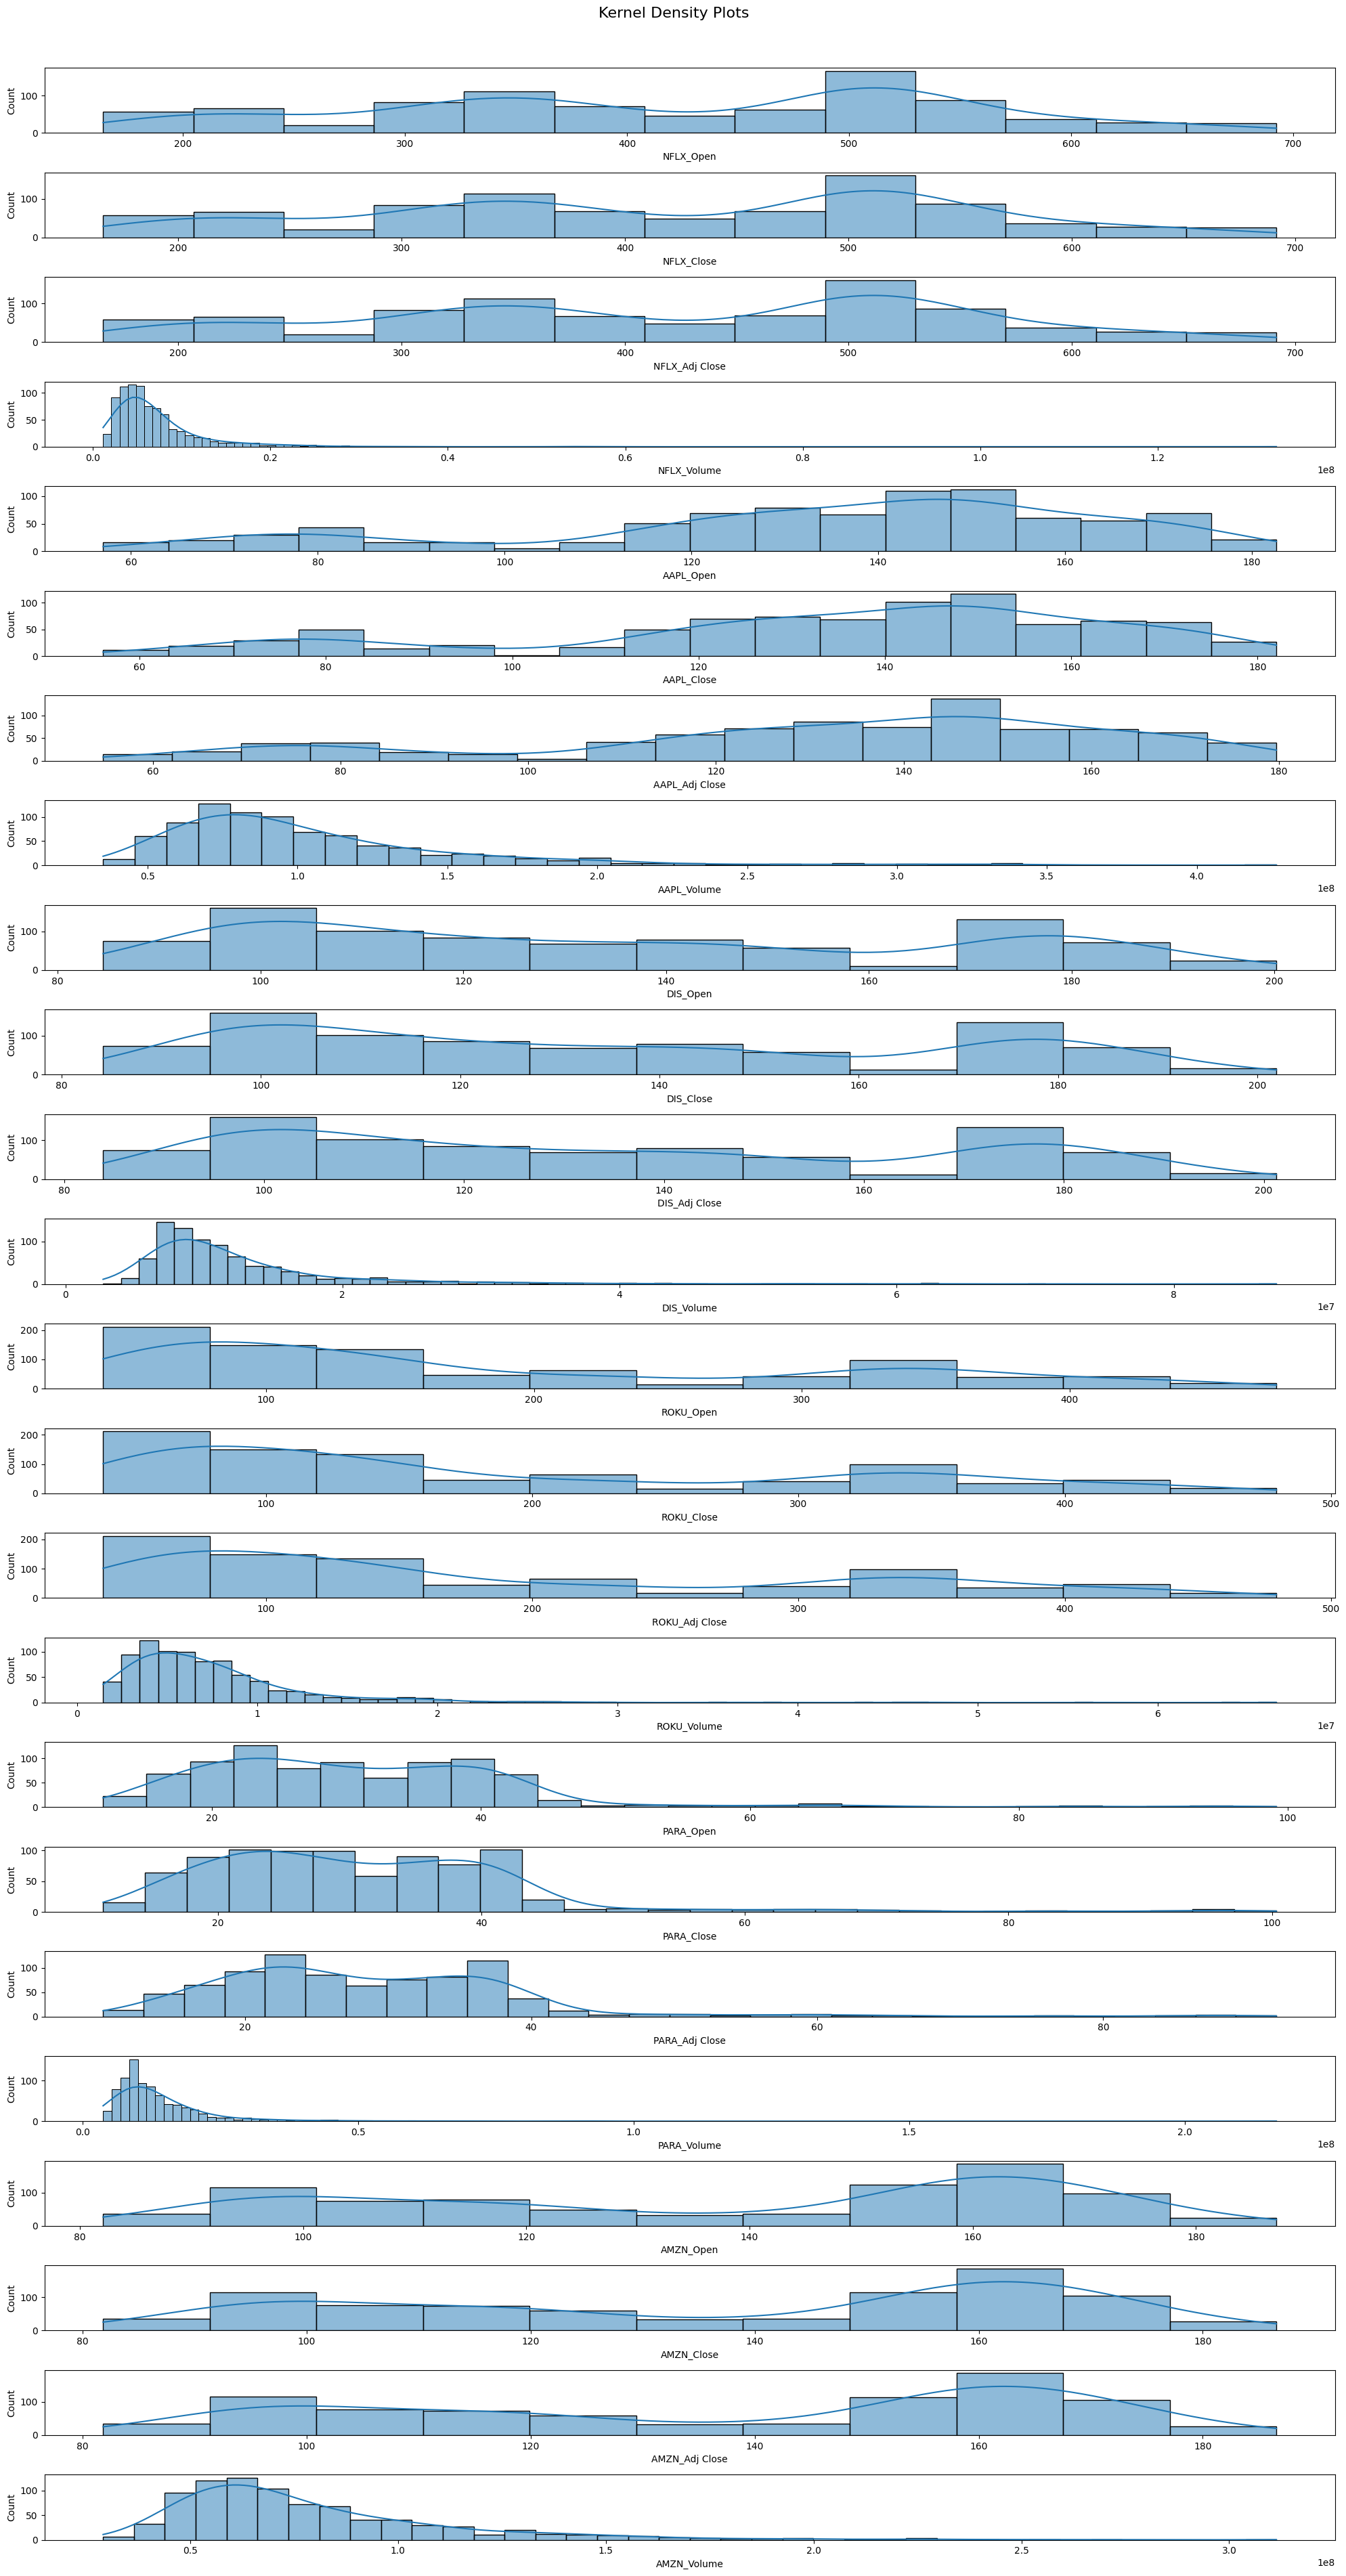

In [ ]:
# Plotting 'price' target variable
fig, ax = plt.subplots(24, 1, figsize=(20, 40))
for i, col in enumerate(final_cols):
    sns.histplot(final_df[col], kde=True, bins="auto", ax=ax[i])
    ax[i].set_xlabel(col)
fig.suptitle("Kernel Density Plots", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## Plotting Adj_Close price for all companies

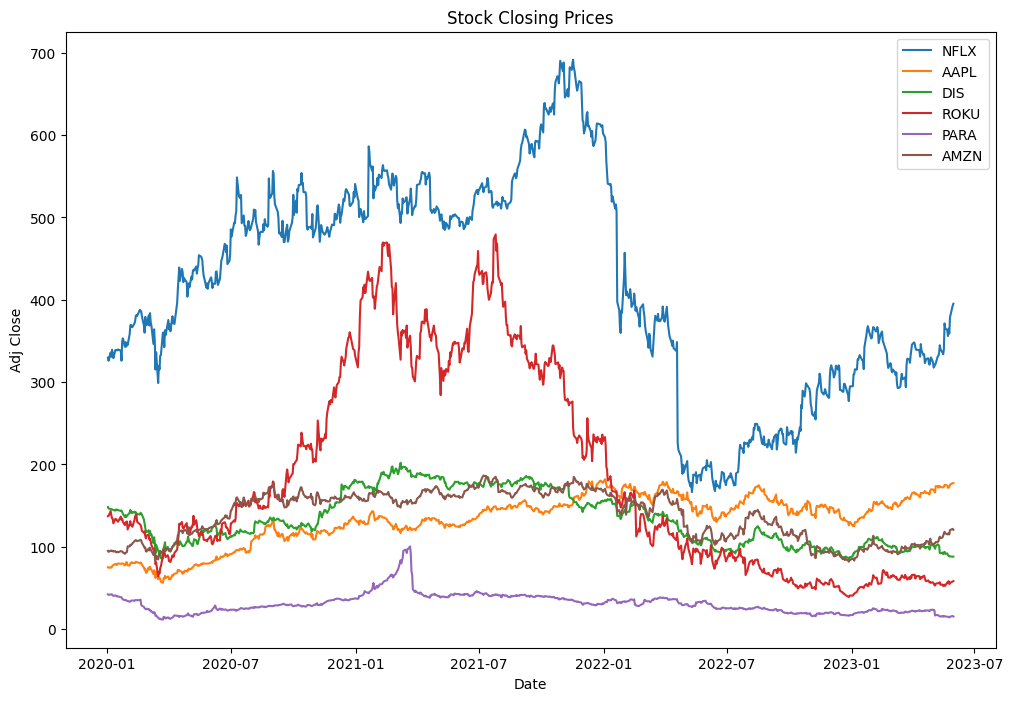

In [ ]:
company_list = ["NFLX", "AAPL", "DIS", "ROKU", "PARA", "AMZN"]
plt.figure(figsize=(12, 8))

for company in company_list:
    plt.plot(final_df[company + "_Close"], label=company)

plt.ylabel("Adj Close")
plt.xlabel("Date")
plt.title("Stock Closing Prices")
plt.legend()
plt.show()

## Plotting Volume of stocks sold for all companies

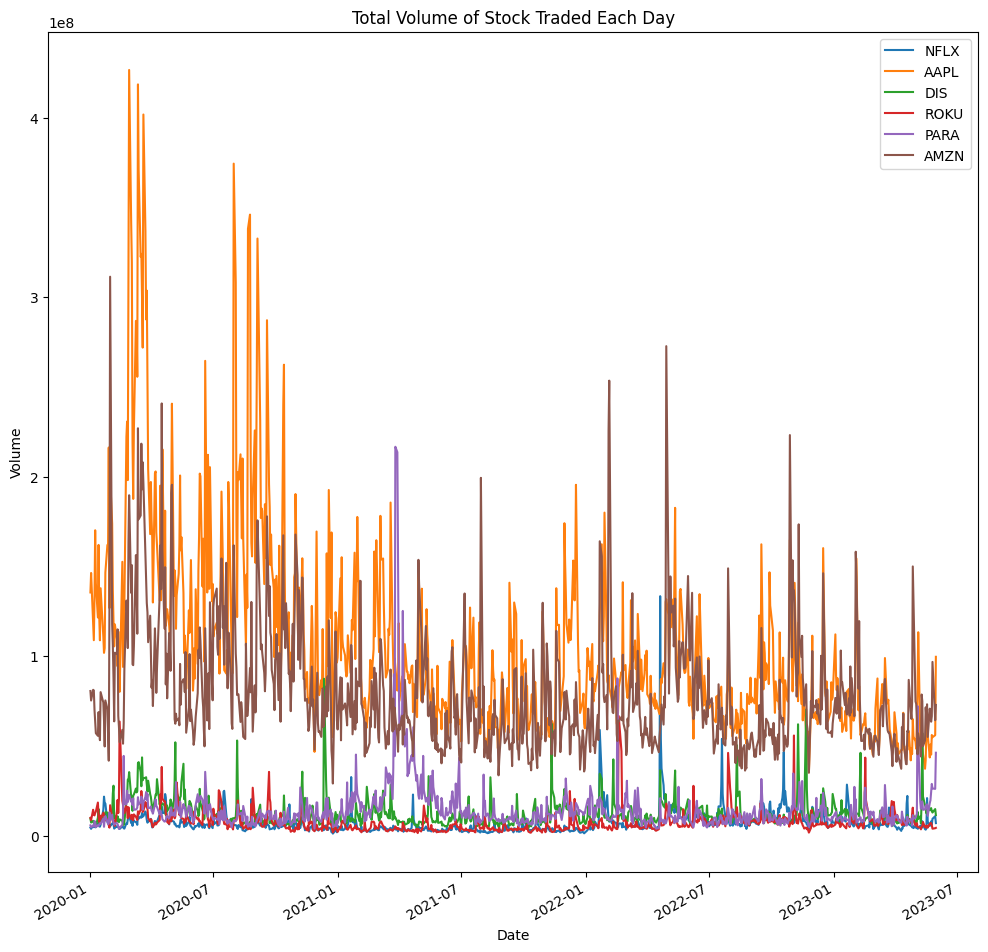

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
plt.title("Total Volume of Stock Traded Each Day")

for company in company_list:
    final_df[company + "_Volume"].plot(label=company)

plt.ylabel("Volume")
plt.xlabel("Date")
plt.legend()
plt.show()

## Pairplot to analyze relationship between Close price of all five company stocks

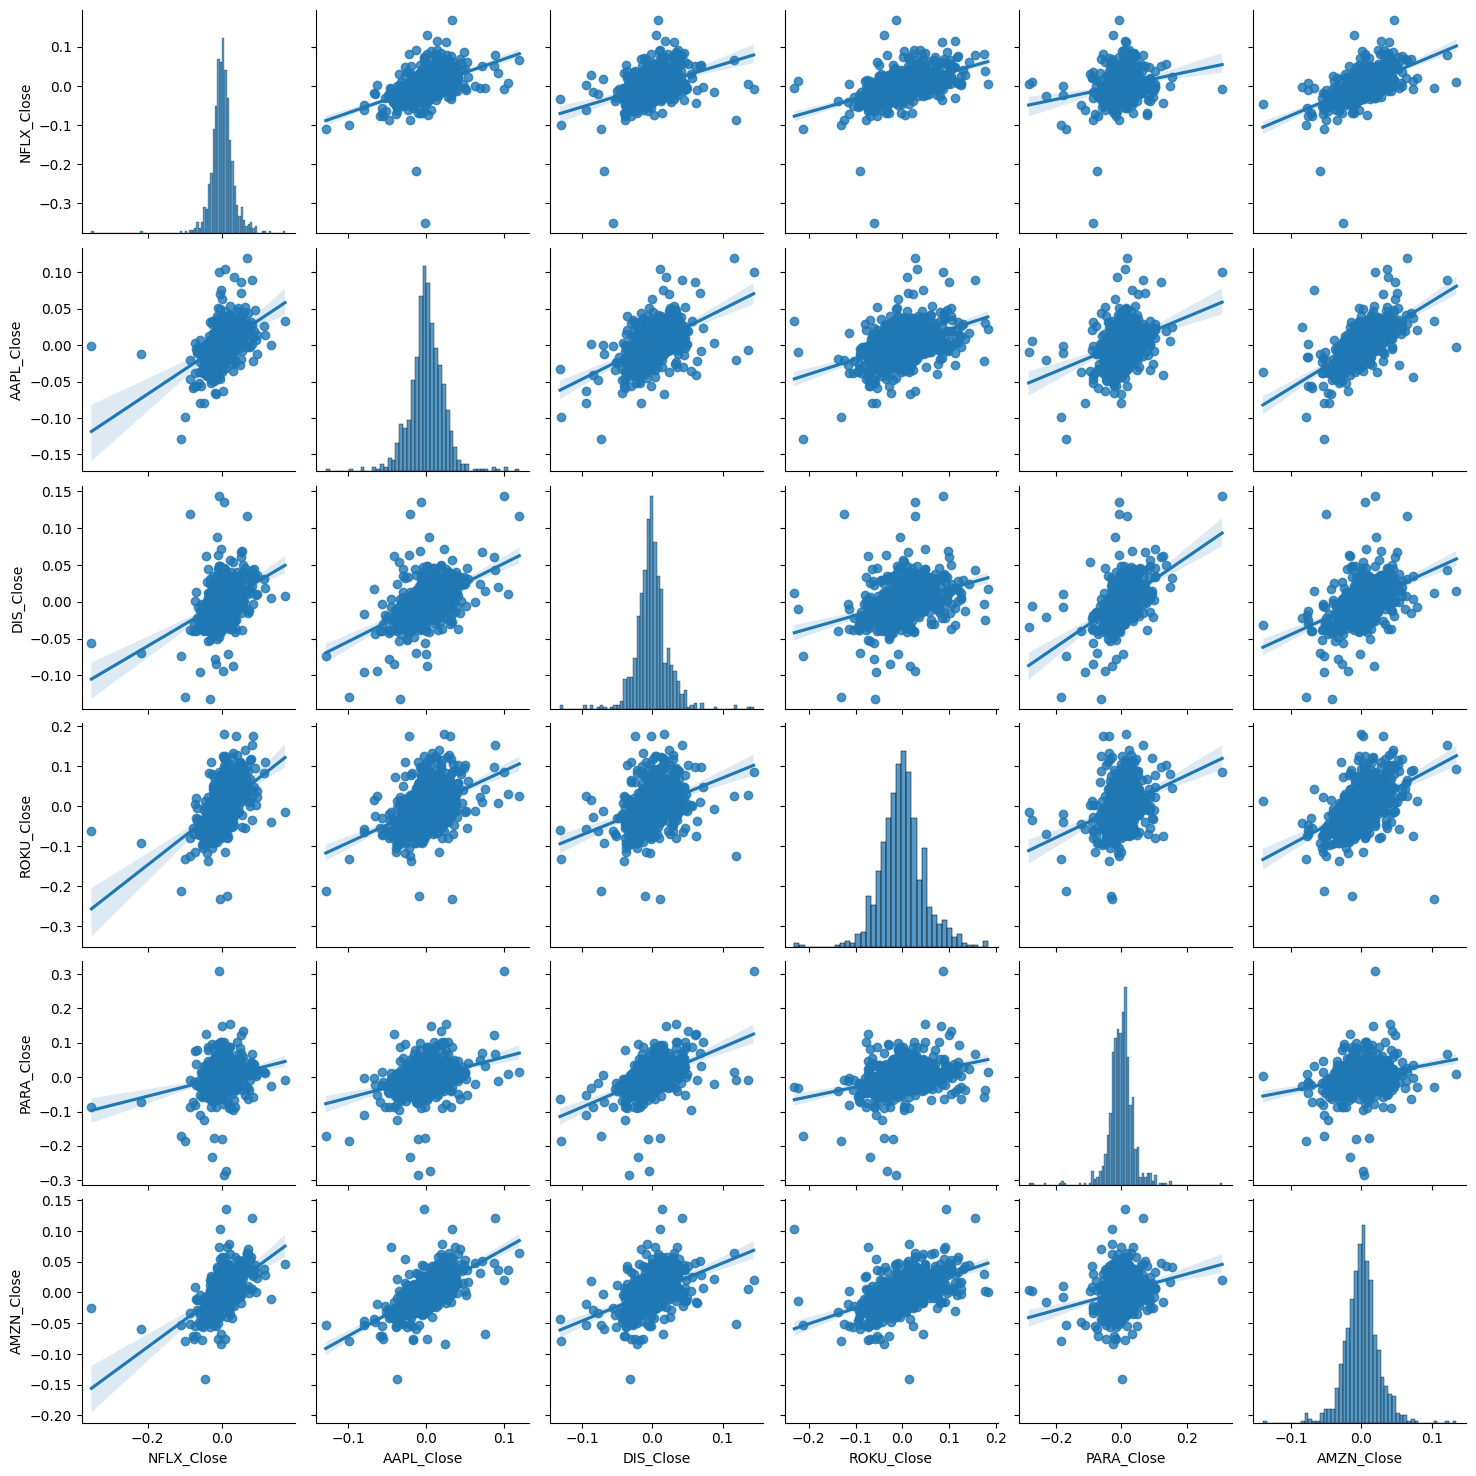

In [ ]:
# Making a new DataFrame for returns
tech_rets = final_df[
    ["NFLX_Close", "AAPL_Close", "DIS_Close", "ROKU_Close", "PARA_Close", "AMZN_Close"]
].pct_change()
sns.pairplot(tech_rets, kind="reg")

## Correlation between Open prices of all five stocks

In [ ]:
final_df[
    ["NFLX_Open", "AAPL_Open", "DIS_Open", "ROKU_Open", "PARA_Open", "AMZN_Open"]
].corr().style.background_gradient(cmap="coolwarm")

## Expected Return vs. Risk

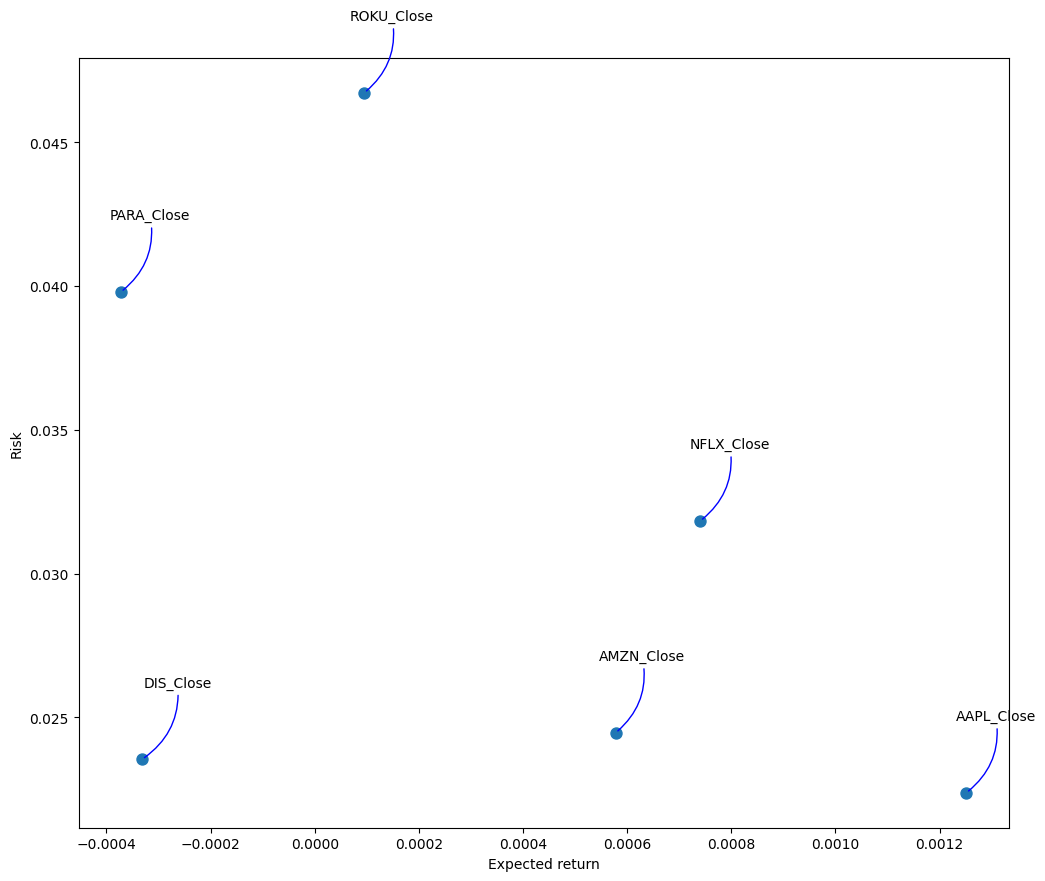

In [ ]:
rets = tech_rets.dropna()
area = np.pi * 20
plt.figure(figsize=(12, 10))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel("Expected return")
plt.ylabel("Risk")
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(50, 50),
        textcoords="offset points",
        ha="right",
        va="bottom",
        arrowprops=dict(arrowstyle="-", color="blue", connectionstyle="arc3,rad=-0.3"),
    )

## Plotting Stock Trend and Pct. Returns

In [ ]:
def plot_stock_trend_and_returns(ticker, titles, start_date, end_date, all_returns):
    # Get the data for this ticker
    prices = yf.download(ticker, start_date, end_date)
    prices = prices.Close

    # prices = web.DataReader(ticker, 'yahoo', start=start_date, end=end_date).Close
    prices.index = [d.date() for d in prices.index]

    plt.figure(figsize=(10, 6))

    # Plot stock price
    plt.subplot(2, 1, 1)
    plt.plot(prices)
    plt.title(titles[0], fontsize=16)
    plt.ylabel("Price ($)", fontsize=14)

    # Plot stock returns
    plt.subplot(2, 1, 2)
    plt.plot(all_returns[0], all_returns[1], color="g")
    plt.title(titles[1], fontsize=16)
    plt.ylabel("Pct. Return", fontsize=14)
    plt.axhline(0, color="k", linestyle="--")

    plt.tight_layout()

    plt.show()

## Stock Performance Analysis

In [ ]:
def perform_analysis_for_stock(
    ticker, start_date, end_date, return_period_weeks, verbose=False
):
    """
    Inputs:
        ticker: the ticker symbol to analyze
        start_date: the first date considered in simulation
        end_date: the last date considered in simulation
        return_period_weeks: the number of weeks in which to calculate returns
        verbose: True if you want to print simulation steps

    Outputs:
        average and standard deviation of returns for simulated runs of this ticker within the given date range
    """

    # Get the data for this ticker
    try:
        prices = yf.download(ticker, start_date, end_date)
        prices = prices.Close
    # Could not find data on this ticker
    except (RemoteDataError, KeyError):
        # Return default values
        return -np.inf, np.inf, None

    prices.index = [d.date() for d in prices.index]

    # This will store all simulated returns
    pct_return_after_period = []
    buy_dates = []

    # Assume we buy the stock on each day in the range
    for buy_date, buy_price in prices.items():
        # Get price of the stock after given number of weeks
        sell_date = buy_date + timedelta(weeks=return_period_weeks)

        try:
            sell_price = prices[prices.index == sell_date].iloc[0]
        # Trying to sell on a non-trading day, skip
        except IndexError:
            continue

        # Compute the percent return
        pct_return = (sell_price - buy_price) / buy_price
        pct_return_after_period.append(pct_return)
        buy_dates.append(buy_date)

        if verbose:
            print("Date Buy: %s, Price Buy: %s" % (buy_date, round(buy_price, 2)))
            print("Date Sell: %s, Price Sell: %s" % (sell_date, round(sell_price, 2)))
            print("Return: %s%%" % round(pct_return * 100, 1))
            print("-------------------")

    # If no data collected return default values
    if len(pct_return_after_period) == 0:
        return -np.inf, np.inf, None

    # Report average and deviation of the percent returns
    return (
        np.mean(pct_return_after_period),
        np.std(pct_return_after_period),
        [buy_dates, pct_return_after_period],
    )


In [ ]:
# Start date for simulation.
# Further back means more training data but risk of including patterns that no longer exist
# More recent means less training data but only using recent patterns
start_date, end_date = datetime(2023, 6, 1), datetime(2023, 12, 1)

# set number of weeks in which you want to see return
return_period_weeks = 4

# Minimum average return
min_avg_return = 0.1

# Maximum volatility in return
max_dev_return = 0.07

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


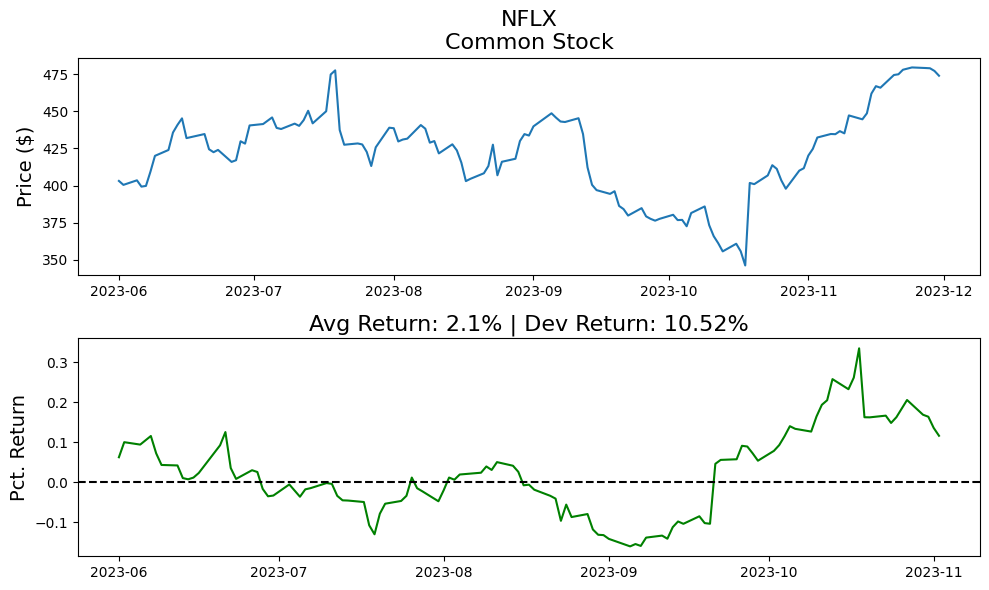

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


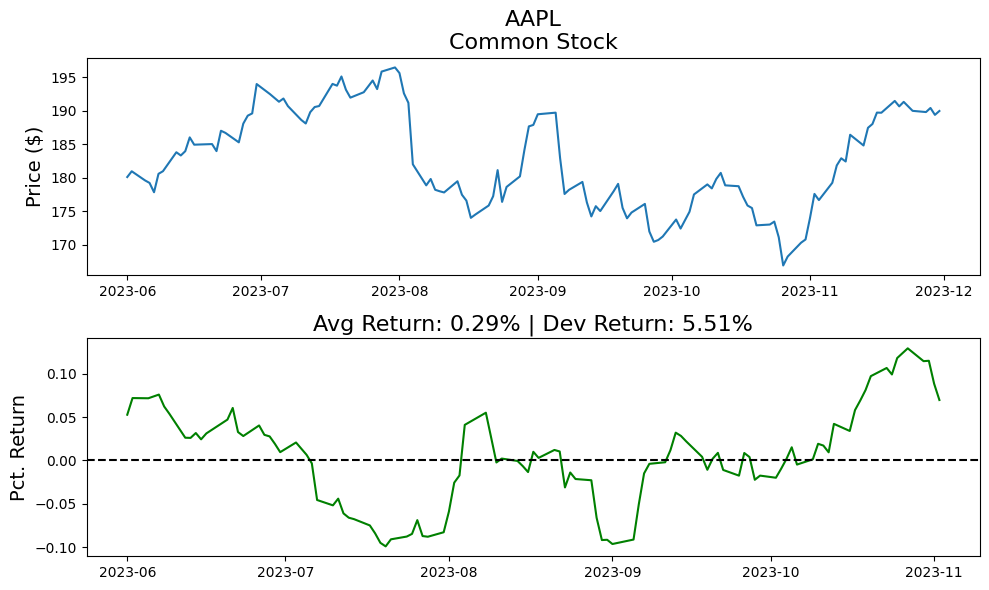

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


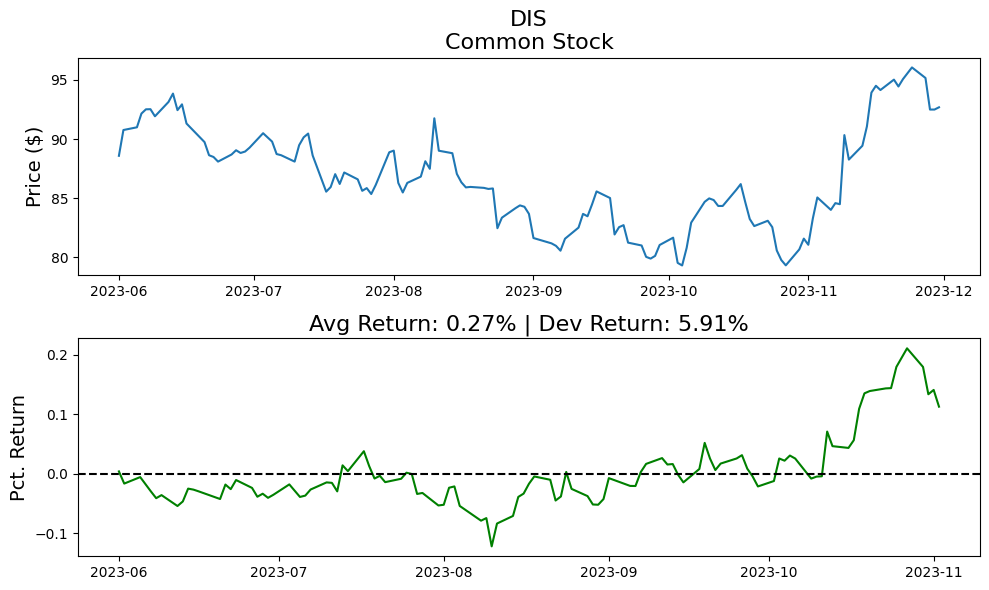

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


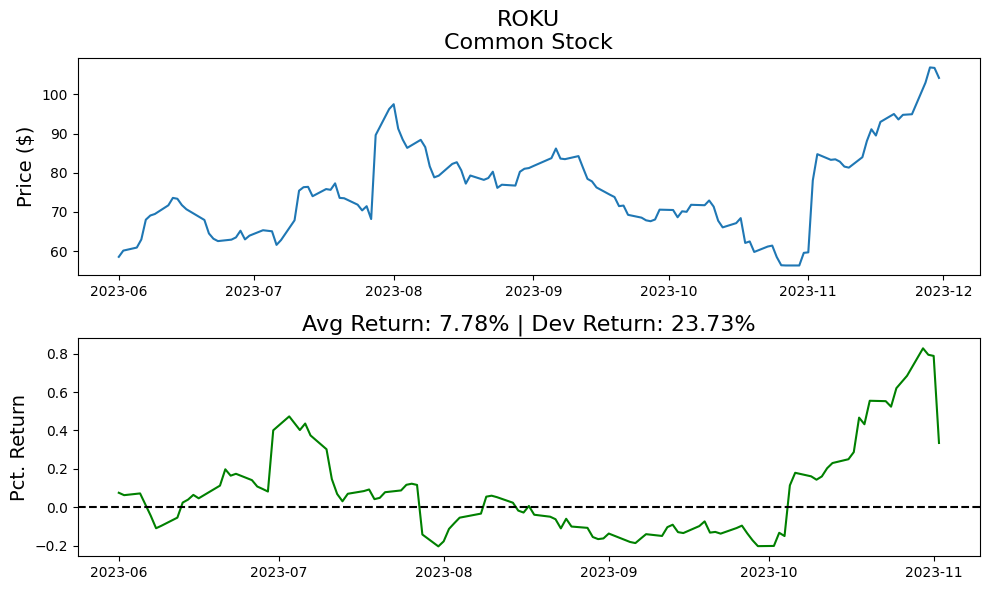

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


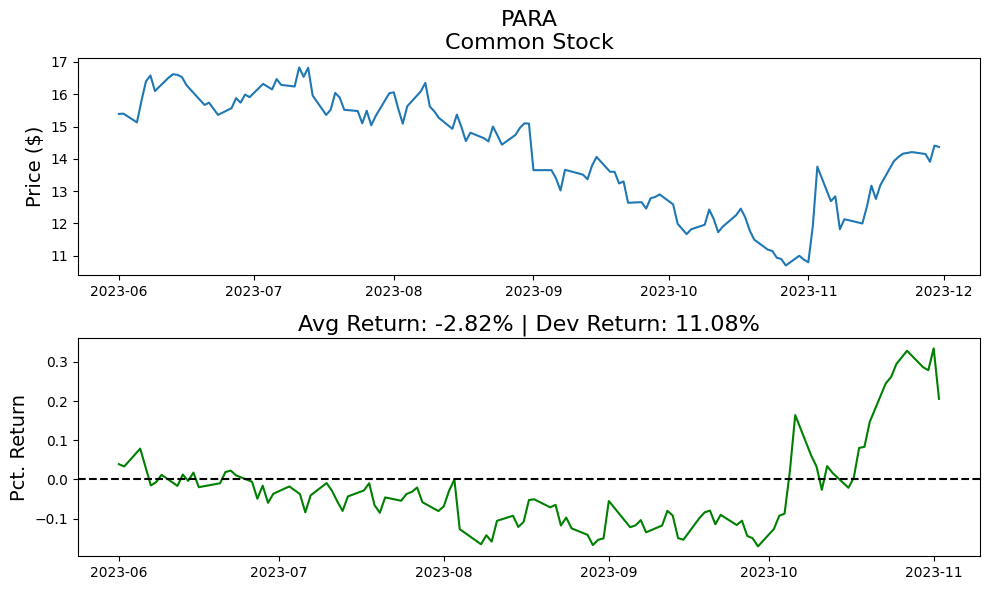

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


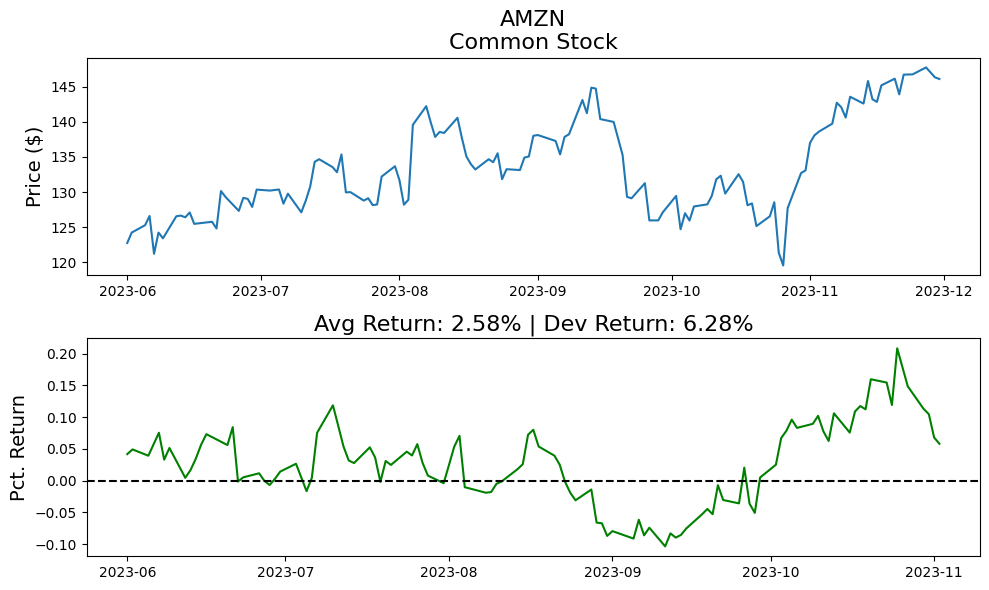

In [ ]:
stocks = ["NFLX", "AAPL", "DIS", "ROKU", "PARA", "AMZN"]
for stock in stocks:
    avg_return, dev_return, all_returns = perform_analysis_for_stock(
        stock, start_date, end_date, return_period_weeks
    )
    title_price = "%s\n%s" % (stock, "Common Stock")
    title_return = "Avg Return: %s%% | Dev Return: %s%%" % (
        round(100 * avg_return, 2),
        round(100 * dev_return, 2),
    )
    plot_stock_trend_and_returns(
        stock, [title_price, title_return], start_date, end_date, all_returns
    )

# Construction of feature database

**Period - 1st Jan 2020 to 31st December 2023**

In [ ]:
# Define dataset start and end date => Two years worth of data
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)

# Downloaded data
NFLX_STOCK = yf.download("NFLX", start_date, end_date)
NFLX_STOCK.describe()

[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
count  1006.000000  1006.000000  1006.000000  1006.000000  1006.000000   
mean    420.121411   426.692683   413.517675   420.203350   420.203350   
std     121.168489   121.664575   120.152690   120.829682   120.829682   
min     163.960007   172.059998   162.710007   166.369995   166.369995   
25%     336.875008   341.902496   331.857498   337.589996   337.589996   
50%     428.870010   436.029999   423.040009   428.304993   428.304993   
75%     509.939995   516.237503   502.657509   509.102486   509.102486   
max     692.349976   700.989990   686.090027   691.690002   691.690002   

             Volume  
count  1.006000e+03  
mean   7.029063e+06  
std    6.790635e+06  
min    1.144000e+06  
25%    3.784625e+06  
50%    5.413550e+06  
75%    7.901450e+06  
max    1.333875e+08

In [ ]:
NFLX_STOCK.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  326.100006  329.980011  324.779999  329.809998  329.809998   
2020-01-03  326.779999  329.859985  325.529999  325.899994  325.899994   
2020-01-06  323.119995  336.359985  321.200012  335.829987  335.829987   
2020-01-07  336.470001  336.700012  330.299988  330.750000  330.750000   
2020-01-08  331.489990  342.700012  331.049988  339.260010  339.260010   

             Volume  
Date                 
2020-01-02  4485800  
2020-01-03  3806900  
2020-01-06  5663100  
2020-01-07  4703200  
2020-01-08  7104500

In [ ]:
NFLX_STOCK["Returns"] = NFLX_STOCK["Adj Close"] - NFLX_STOCK["Adj Close"].shift(1)
NFLX_STOCK.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  326.100006  329.980011  324.779999  329.809998  329.809998   
2020-01-03  326.779999  329.859985  325.529999  325.899994  325.899994   
2020-01-06  323.119995  336.359985  321.200012  335.829987  335.829987   
2020-01-07  336.470001  336.700012  330.299988  330.750000  330.750000   
2020-01-08  331.489990  342.700012  331.049988  339.260010  339.260010   

             Volume   Returns  
Date                           
2020-01-02  4485800       NaN  
2020-01-03  3806900 -3.910004  
2020-01-06  5663100  9.929993  
2020-01-07  4703200 -5.079987  
2020-01-08  7104500  8.510010

Calculating daily returns:

Produce the day's difference of the stock dataframe: (np.log(nflx['Open']) - np.log(nflx['Open'].shift(+1)))

When we take the logarithm of the ratio between today's closing price and yesterday's, we're essentially computing the daily percentage change in the stock price. Using logarithms in return calculations helps us handle the additive nature of log-returns, making overall return calculations more interpretable and facilitating mathematical operations.

In [ ]:
# Daily return
NFLX_STOCK["Daily_Return"] = np.log(NFLX_STOCK["Adj Close"]) - np.log(NFLX_STOCK["Adj Close"].shift(1))
NFLX_STOCK = NFLX_STOCK.dropna()
NFLX_STOCK.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-03  326.779999  329.859985  325.529999  325.899994  325.899994   
2020-01-06  323.119995  336.359985  321.200012  335.829987  335.829987   
2020-01-07  336.470001  336.700012  330.299988  330.750000  330.750000   
2020-01-08  331.489990  342.700012  331.049988  339.260010  339.260010   
2020-01-09  342.000000  343.420013  334.609985  335.660004  335.660004   

             Volume   Returns  Daily_Return  
Date                                         
2020-01-03  3806900 -3.910004     -0.011926  
2020-01-06  5663100  9.929993      0.030014  
2020-01-07  4703200 -5.079987     -0.015242  
2020-01-08  7104500  8.510010      0.025404  
2020-01-09  4709300 -3.600006     -0.010668


**Feature-set 1: Typical Price, Typical_Price_Return**


`Mid_Price` is the mean value of Open and Close values

In [ ]:
NFLX_STOCK["Mid_Price"] = NFLX_STOCK[["Open", "Close"]].mean(axis=1)
NFLX_STOCK["Mid_Price_Return"] = (
    np.log(NFLX_STOCK.Mid_Price) - np.log(NFLX_STOCK.Mid_Price.shift(+1))
) * 100.0
NFLX_STOCK = NFLX_STOCK.dropna()
NFLX_STOCK.head()

<ipython-input-28-9acf4a380c30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NFLX_STOCK["Mid_Price"] = NFLX_STOCK[["Open", "Close"]].mean(axis=1)
<ipython-input-28-9acf4a380c30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NFLX_STOCK["Mid_Price_Return"] = (


Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-06  323.119995  336.359985  321.200012  335.829987  335.829987   
2020-01-07  336.470001  336.700012  330.299988  330.750000  330.750000   
2020-01-08  331.489990  342.700012  331.049988  339.260010  339.260010   
2020-01-09  342.000000  343.420013  334.609985  335.660004  335.660004   
2020-01-10  337.130005  338.500000  327.269989  329.049988  329.049988   

             Volume   Returns  Daily_Return   Mid_Price  Mid_Price_Return  
Date                                                                       
2020-01-06  5663100  9.929993      0.030014  329.474991          0.956068  
2020-01-07  4703200 -5.079987     -0.015242  333.610001          1.247220  
2020-01-08  7104500  8.510010      0.025404  335.375000          0.527666  
2020-01-09  4709300 -3.600006     -0.010668  338.830002          1.024920  
2020-01-10  4718300 -6.610016     -0.019889  333.089996         -1.708580

**Feature-set 2: Common Transforms**

* log of price
* pct_change of returns
* difference in returns
* log of 5 day moving average of price
* Daily returns vs. 200 day moving average
* Daily closing price vs. 50 day exponential moving average




In [ ]:
NFLX_STOCK["Price_Log"] = np.log(NFLX_STOCK.Mid_Price)
NFLX_STOCK["Returns_Differencing"] = NFLX_STOCK.Returns.diff()
NFLX_STOCK["Returns_Differencing_10"] = NFLX_STOCK.Returns.diff(10)
NFLX_STOCK["Returns_Percent_Change"] = NFLX_STOCK.Returns.pct_change()

In [ ]:
# Log of 5 day moving average of volume
NFLX_STOCK["MA_5"] = np.log(NFLX_STOCK.Mid_Price.rolling(5).mean())

# Daily volume vs. 200 day moving average
NFLX_STOCK["Volumne_MA_200"] = (
    NFLX_STOCK.Mid_Price / NFLX_STOCK.Returns.rolling(200).mean() - 1
)

# Daily closing price vs. 50 day Exponential Moving Avg
NFLX_STOCK["Close_EMA_50"] = NFLX_STOCK.Close / NFLX_STOCK.Close.ewm(span=50).mean() - 1

**Feature-set 3: Momentum Indicators**

1. AwesomeOscillatorIndicator

In [ ]:
NFLX_STOCK['Momentum_AwesomeOscillatorIndicator'] = ta.momentum.AwesomeOscillatorIndicator(NFLX_STOCK.High, NFLX_STOCK.Low,window1 = 5,window2 = 34, fillna=False).awesome_oscillator()

2. Kaufman’s Adaptive Moving Average (KAMA)



In [ ]:
NFLX_STOCK['Momentum_KAMA'] = ta.momentum.KAMAIndicator(NFLX_STOCK.Close, fillna=False).kama()

3. PercentagePriceOscillator

In [ ]:
NFLX_STOCK['Momentum_PercentagePVolumneOscillator'] = ta.momentum.PercentageVolumeOscillator(NFLX_STOCK.Volume, fillna=False).pvo()

4. Rate of Change (ROC)

In [ ]:
NFLX_STOCK['Momentum_ROC'] = ta.momentum.ROCIndicator(NFLX_STOCK.Close, fillna=False).roc()

5. Relative Strength Index (RSI)

In [ ]:
NFLX_STOCK['Momentum_RSI'] = ta.momentum.RSIIndicator(NFLX_STOCK.Close, fillna=False).rsi()

6. Stochastic RSI

In [ ]:
NFLX_STOCK['Momentum_StochRSIIndicator'] = ta.momentum.StochRSIIndicator(NFLX_STOCK.Close, fillna=False).stochrsi()

7. True strength index (TSI)

In [ ]:
NFLX_STOCK['Momentum_TSIIndicator'] = ta.momentum.TSIIndicator(NFLX_STOCK.Close, fillna=False).tsi()

**Feature-set 4: Trend Indicators**

1. Average Directional Movement Index (ADX)

In [ ]:
NFLX_STOCK['Trend_ADX'] = ta.trend.ADXIndicator(NFLX_STOCK.High,NFLX_STOCK.Low, NFLX_STOCK.Close, window = 20,fillna=False).adx()

2. Aroon Indicator

In [ ]:
NFLX_STOCK['Trend_AroonIndicator'] = ta.trend.AroonIndicator(NFLX_STOCK.Close, NFLX_STOCK.Low, window=20, fillna=False).aroon_indicator()

3. Commodity Channel Index (CCI)


In [ ]:
NFLX_STOCK['Trend_CCI'] = ta.trend.CCIIndicator(NFLX_STOCK.High, NFLX_STOCK.Low, NFLX_STOCK.Close, window = 20,fillna=False).cci()

4. Detrended Price Oscillator (DPO)

In [ ]:
NFLX_STOCK['Trend_DPO'] = ta.trend.DPOIndicator(NFLX_STOCK.Close, window = 20, fillna=False).dpo()

5. EMA - Exponential Moving Average


In [ ]:
NFLX_STOCK['Trend_EMA'] = ta.trend.EMAIndicator(NFLX_STOCK.Close, window = 20, fillna=False).ema_indicator()

6. Moving Average Convergence Divergence (MACD)

In [ ]:
NFLX_STOCK['Trend_MACD'] = ta.trend.MACD(NFLX_STOCK.Close, fillna=False).macd()

7. Mass Index (MI)

In [ ]:
NFLX_STOCK['Trend_MI'] = ta.trend.MassIndex(NFLX_STOCK.High, NFLX_STOCK.Low, fillna=False).mass_index()

**Feature-set 5: Volumne Indicator**

1. Chaikin Money Flow (CMF)

In [ ]:
NFLX_STOCK['Volumne_CMF'] = ta.volume.ChaikinMoneyFlowIndicator(NFLX_STOCK.High,NFLX_STOCK.Low,NFLX_STOCK.Close, NFLX_STOCK.Volume,window = 20,fillna=False).chaikin_money_flow()

2. Ease of movement (EoM, EMV)

In [ ]:
NFLX_STOCK['Volumne_EOM'] = ta.volume.EaseOfMovementIndicator(NFLX_STOCK.High,NFLX_STOCK.Low, NFLX_STOCK.Volume,window = 20,fillna=False).ease_of_movement()

3. Force Index (FI)

In [ ]:
NFLX_STOCK['Volumne_FI'] = ta.volume.ForceIndexIndicator(NFLX_STOCK.Close, NFLX_STOCK.Volume,window = 20,fillna=False).force_index()

4. Money Flow Index (MFI)

In [ ]:
NFLX_STOCK['Volumne_MFI'] = ta.volume.money_flow_index(NFLX_STOCK.High, NFLX_STOCK.Low, NFLX_STOCK.Close,NFLX_STOCK.Volume, window=20, fillna=False)

5. Volume Weighted Average Price (VWAP)

In [ ]:
NFLX_STOCK['Volumne_VWAP'] = ta.volume.VolumeWeightedAveragePrice(NFLX_STOCK.High, NFLX_STOCK.Low, NFLX_STOCK.Close,NFLX_STOCK.Volume, window=20, fillna=False).volume_weighted_average_price()

**Feature-set 6: Volatility Indicators**

1. Average True Range (ATR)

In [ ]:
NFLX_STOCK['Volatility_ATR'] = ta.volatility.AverageTrueRange(NFLX_STOCK.High, NFLX_STOCK.Low, NFLX_STOCK.Close, window=20, fillna=False).average_true_range()

2. Bollinger Bands

In [ ]:
NFLX_STOCK['Volatility_BB'] = ta.volatility.BollingerBands(NFLX_STOCK.Close, window=20, fillna=False).bollinger_wband()

3. Donchian Channel

In [ ]:
NFLX_STOCK['Volatility_DonchainChannel'] = ta.volatility.DonchianChannel(NFLX_STOCK.High, NFLX_STOCK.Low,NFLX_STOCK.Close, window=20, fillna=False).donchian_channel_wband()

4. Ulcer Index

In [ ]:
NFLX_STOCK['Volatility_UlcerIndex'] = ta.volatility.UlcerIndex(NFLX_STOCK.Close, window=20, fillna=False).ulcer_index()

5. Keltner channel (KC)

In [ ]:
NFLX_STOCK['Volatility_KeltnerChannel'] = ta.volatility.keltner_channel_hband(NFLX_STOCK.High, NFLX_STOCK.Low,NFLX_STOCK.Close, window=20, fillna=False)

In [ ]:
NFLX_STOCK.dropna(inplace = True)

****Feature-set 7: Fama-French 5 Factors Indicators****

In [ ]:
df_fama = pd.read_csv("/content/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)
df_fama = df_fama.iloc[:-1]
df_fama.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
df_fama['Date'] = pd.to_datetime(df_fama['Date'], format='%Y%m%d')
df_fama = df_fama[(df_fama["Date"] >= start_date) & (df_fama["Date"] <= end_date)]
fama = df_fama.set_index("Date")

In [ ]:
fama.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  1006 non-null   float64
 1   SMB     1006 non-null   float64
 2   HML     1006 non-null   float64
 3   RMW     1006 non-null   float64
 4   CMA     1006 non-null   float64
 5   RF      1006 non-null   float64
dtypes: float64(6)
memory usage: 55.0 KB


In [ ]:
NFLX_STOCK = pd.concat([NFLX_STOCK, fama], axis=1)
NFLX_STOCK.dropna(inplace=True)
NFLX_STOCK

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-10-19  537.070007  541.799988  525.380005  530.719971  530.719971   
2020-10-20  528.140015  533.780029  522.260010  525.419983  525.419983   
2020-10-21  501.029999  506.850006  488.250000  489.049988  489.049988   
2020-10-22  494.690002  495.140015  482.000000  485.230011  485.230011   
2020-10-23  488.109985  490.059998  481.350006  488.279999  488.279999   
...                ...         ...         ...         ...         ...   
2023-12-22  494.000000  496.019989  485.450012  486.760010  486.760010   
2023-12-26  489.390015  491.480011  486.380005  491.190002  491.190002   
2023-12-27  491.239990  494.019989  489.250000  491.790009  491.790009   
2023-12-28  492.000000  492.890015  489.070007  490.510010  490.510010   
2023-12-29  490.369995  492.230011  481.940002  486.880005  486.880005   

                Volume    Returns  Daily_Return   Mid_Price  Mid_Price_Return  \
Date                                                                            
2020-10-19   7567500.0  -0.070007     -0.000132  533.894989         -1.163843   
2020-10-20  10047200.0  -5.299988     -0.010037  526.779999         -1.341617   
2020-10-21  17405700.0 -36.369995     -0.071733  495.039993         -6.214445   
2020-10-22   6997900.0  -3.819977     -0.007842  489.960007         -1.031479   
2020-10-23   4927900.0   3.049988      0.006266  488.194992         -0.360887   
...                ...        ...           ...         ...               ...   
2023-12-22   2701100.0  -4.849976     -0.009914  490.380005         -0.357245   
2023-12-26   2034500.0   4.429993      0.009060  490.290009         -0.018354   
2023-12-27   2561300.0   0.600006      0.001221  491.514999          0.249539   
2023-12-28   1710500.0  -1.279999     -0.002606  491.255005         -0.052911   
2023-12-29   2739500.0  -3.630005     -0.007428  488.625000         -0.536803   

            ...  Volatility_BB  Volatility_DonchainChannel  \
Date        ...                                              
2020-10-19  ...      19.295467                   20.317010   
2020-10-20  ...      18.813994                   20.249699   
2020-10-21  ...      17.646928                   20.213643   
2020-10-22  ...      16.807716                   20.149451   
2020-10-23  ...      16.480714                   18.239968   
...         ...            ...                         ...   
2023-12-22  ...      12.108391                   11.698648   
2023-12-26  ...      12.560981                   11.683756   
2023-12-27  ...      13.008641                   11.667951   
2023-12-28  ...      13.378691                   11.651536   
2023-12-29  ...      13.588587                   11.635671   

            Volatility_UlcerIndex  Volatility_KeltnerChannel  Mkt-RF   SMB  \
Date                                                                         
2020-10-19               7.817424                 532.762331   -1.53  0.35   
2020-10-20               7.453237                 534.697165    0.34 -0.09   
2020-10-21               7.107593                 535.416831   -0.36 -0.47   
2020-10-22               6.855180                 536.356000    0.67  0.95   
2020-10-23               6.729490                 536.348000    0.38  0.37   
...                           ...                        ...     ...   ...   
2023-12-22               3.269975                 481.585167    0.21  0.61   
2023-12-26               3.274498                 482.049834    0.48  0.81   
2023-12-27               3.277643                 482.721001    0.16  0.16   
2023-12-28               3.282108                 483.250335   -0.01 -0.38   
2023-12-29               3.292339                 483.990837   -0.43 -1.13   

             HML   RMW   CMA     RF  
Date                                 
2020-10-19  0.31 -0.35 -0.24  0.000  
2020-10-20  1.26  0.55  0.17  0.000  
2020-10-21  0.41  0.53 -0.0

**Feature-set 8: Exracting external factors using Fred API**

In [ ]:
from fredapi import Fred
key = "605fa38bc581dd058d0a16c59ef616d7"
fred = Fred(api_key=key)

In [ ]:
# UK Pound to U.S. Dollar Spot Exchange Rate
# U.S. Dollars to Euro Spot Exchange Rate
# Corporate bond yield
# Coinbase Bitcoin

feat_list = ["SP500","DEXUSUK", "DEXUSEU","DAAA" ,"CBBTCUSD"]
feat_df = pd.DataFrame()
for feat in feat_list:
    feature = fred.get_series(feat, start_date, end_date)
    feature = feature.to_frame(feat)
    feature.dropna(inplace=True)
    feat_df = pd.concat([feat_df, feature], axis=1)
feat_df.dropna(inplace=True)
feat_df

SP500  DEXUSUK  DEXUSEU  DAAA  CBBTCUSD
2020-01-02  3257.85   1.3128   1.1166  3.00   6945.01
2020-01-03  3234.85   1.3091   1.1173  2.94   7335.54
2020-01-06  3246.28   1.3163   1.1187  3.01   7773.48
2020-01-07  3237.18   1.3127   1.1138  3.02   8169.95
2020-01-08  3253.05   1.3110   1.1117  3.10   8035.08
...             ...      ...      ...   ...       ...
2023-12-22  4754.63   1.2720   1.1008  4.70  44015.60
2023-12-26  4774.75   1.2709   1.1035  4.68  42520.26
2023-12-27  4781.58   1.2797   1.1114  4.57  43444.45
2023-12-28  4783.35   1.2743   1.1073  4.61  42613.04
2023-12-29  4769.83   1.2743   1.1062  4.65  42056.30

[993 rows x 5 columns]

In [ ]:
NFLX_STOCK = pd.concat([NFLX_STOCK, feat_df], axis=1)
NFLX_STOCK.dropna(inplace=True)
NFLX_STOCK

Open        High         Low       Close   Adj Close  \
2020-10-19  537.070007  541.799988  525.380005  530.719971  530.719971   
2020-10-20  528.140015  533.780029  522.260010  525.419983  525.419983   
2020-10-21  501.029999  506.850006  488.250000  489.049988  489.049988   
2020-10-22  494.690002  495.140015  482.000000  485.230011  485.230011   
2020-10-23  488.109985  490.059998  481.350006  488.279999  488.279999   
...                ...         ...         ...         ...         ...   
2023-12-22  494.000000  496.019989  485.450012  486.760010  486.760010   
2023-12-26  489.390015  491.480011  486.380005  491.190002  491.190002   
2023-12-27  491.239990  494.019989  489.250000  491.790009  491.790009   
2023-12-28  492.000000  492.890015  489.070007  490.510010  490.510010   
2023-12-29  490.369995  492.230011  481.940002  486.880005  486.880005   

                Volume    Returns  Daily_Return   Mid_Price  Mid_Price_Return  \
2020-10-19   7567500.0  -0.070007     -0.000132  533.894989         -1.163843   
2020-10-20  10047200.0  -5.299988     -0.010037  526.779999         -1.341617   
2020-10-21  17405700.0 -36.369995     -0.071733  495.039993         -6.214445   
2020-10-22   6997900.0  -3.819977     -0.007842  489.960007         -1.031479   
2020-10-23   4927900.0   3.049988      0.006266  488.194992         -0.360887   
...                ...        ...           ...         ...               ...   
2023-12-22   2701100.0  -4.849976     -0.009914  490.380005         -0.357245   
2023-12-26   2034500.0   4.429993      0.009060  490.290009         -0.018354   
2023-12-27   2561300.0   0.600006      0.001221  491.514999          0.249539   
2023-12-28   1710500.0  -1.279999     -0.002606  491.255005         -0.052911   
2023-12-29   2739500.0  -3.630005     -0.007428  488.625000         -0.536803   

            ...   SMB   HML   RMW   CMA     RF    SP500  DEXUSUK  DEXUSEU  \
2020-10-19  ...  0.35  0.31 -0.35 -0.24  0.000  3426.92   1.2998   1.1788   
2020-10-20  ... -0.09  1.26  0.55  0.17  0.000  3443.12   1.2951   1.1824   
2020-10-21  ... -0.47  0.41  0.53 -0.01  0.000  3435.56   1.3143   1.1870   
2020-10-22  ...  0.95  1.03 -0.58 -0.08  0.000  3453.49   1.3090   1.1824   
2020-10-23  ...  0.37  0.03 -0.14 -0.35  0.000  3465.39   1.3039   1.1844   
...         ...   ...   ...   ...   ...    ...      ...      ...      ...   
2023-12-22  ...  0.61  0.09 -0.64  0.19  0.021  4754.63   1.2720   1.1008   
2023-12-26  ...  0.81  0.46 -0.34 -0.15  0.021  4774.75   1.2709   1.1035   
2023-12-27  ...  0.16  0.12 -0.31 -0.14  0.021  4781.58   1.2797   1.1114   
2023-12-28  ... -0.38  0.03 -0.32  0.15  0.021  4783.35   1.2743   1.1073   
2023-12-29  ... -1.13 -0.37  0.68 -0.07  0.021  4769.83   1.2743   1.1062   

            DAAA  CBBTCUSD  
2020-10-19  2.29  11765.09  
2020-10-20  2.36  11917.34  
2020-10-21  2.40  12836.37  
2020-10-22  2.43  12977.02  
2020-10-23  2.41  12943.03  
...          ...       ...  
2023-12-22  4.70  44015.60  
2023-12-26  4.68  42520.26  
2023-12-27  4.57  43444.45  
2023-12-28  4.61  42613.04  
2023-12-29  4.65  42056.30  

[794 rows x 52 columns]

**Feature-set 8: ADS features**

In [ ]:
ads = pd.read_excel("/content/ADS_Index_Most_Current_Vintage.xlsx")
ads.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
ads["Date"] = pd.to_datetime(ads["Date"], format="%Y:%m:%d")
ads = ads[(ads["Date"] >= start_date) & (ads["Date"] <= end_date)]
ads = ads.set_index("Date")
ads

ADS_Index
Date                 
2020-01-01  -0.349517
2020-01-02  -0.335775
2020-01-03  -0.322146
2020-01-04  -0.308624
2020-01-05  -0.295203
...               ...
2023-12-27  -0.105230
2023-12-28  -0.123164
2023-12-29  -0.142330
2023-12-30  -0.162736
2023-12-31  -0.184390

[1461 rows x 1 columns]

In [ ]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2020-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ADS_Index  1461 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


**Final Dataframe "NFLX_STOCK" is created by gathering all the required data from various features**

In [ ]:
NFLX_STOCK = pd.concat([NFLX_STOCK, ads], axis=1)
NFLX_STOCK.dropna(inplace=True)
NFLX_STOCK

Open        High         Low       Close   Adj Close  \
2020-10-19  537.070007  541.799988  525.380005  530.719971  530.719971   
2020-10-20  528.140015  533.780029  522.260010  525.419983  525.419983   
2020-10-21  501.029999  506.850006  488.250000  489.049988  489.049988   
2020-10-22  494.690002  495.140015  482.000000  485.230011  485.230011   
2020-10-23  488.109985  490.059998  481.350006  488.279999  488.279999   
...                ...         ...         ...         ...         ...   
2023-12-22  494.000000  496.019989  485.450012  486.760010  486.760010   
2023-12-26  489.390015  491.480011  486.380005  491.190002  491.190002   
2023-12-27  491.239990  494.019989  489.250000  491.790009  491.790009   
2023-12-28  492.000000  492.890015  489.070007  490.510010  490.510010   
2023-12-29  490.369995  492.230011  481.940002  486.880005  486.880005   

                Volume    Returns  Daily_Return   Mid_Price  Mid_Price_Return  \
2020-10-19   7567500.0  -0.070007     -0.000132  533.894989         -1.163843   
2020-10-20  10047200.0  -5.299988     -0.010037  526.779999         -1.341617   
2020-10-21  17405700.0 -36.369995     -0.071733  495.039993         -6.214445   
2020-10-22   6997900.0  -3.819977     -0.007842  489.960007         -1.031479   
2020-10-23   4927900.0   3.049988      0.006266  488.194992         -0.360887   
...                ...        ...           ...         ...               ...   
2023-12-22   2701100.0  -4.849976     -0.009914  490.380005         -0.357245   
2023-12-26   2034500.0   4.429993      0.009060  490.290009         -0.018354   
2023-12-27   2561300.0   0.600006      0.001221  491.514999          0.249539   
2023-12-28   1710500.0  -1.279999     -0.002606  491.255005         -0.052911   
2023-12-29   2739500.0  -3.630005     -0.007428  488.625000         -0.536803   

            ...   HML   RMW   CMA     RF    SP500  DEXUSUK  DEXUSEU  DAAA  \
2020-10-19  ...  0.31 -0.35 -0.24  0.000  3426.92   1.2998   1.1788  2.29   
2020-10-20  ...  1.26  0.55  0.17  0.000  3443.12   1.2951   1.1824  2.36   
2020-10-21  ...  0.41  0.53 -0.01  0.000  3435.56   1.3143   1.1870  2.40   
2020-10-22  ...  1.03 -0.58 -0.08  0.000  3453.49   1.3090   1.1824  2.43   
2020-10-23  ...  0.03 -0.14 -0.35  0.000  3465.39   1.3039   1.1844  2.41   
...         ...   ...   ...   ...    ...      ...      ...      ...   ...   
2023-12-22  ...  0.09 -0.64  0.19  0.021  4754.63   1.2720   1.1008  4.70   
2023-12-26  ...  0.46 -0.34 -0.15  0.021  4774.75   1.2709   1.1035  4.68   
2023-12-27  ...  0.12 -0.31 -0.14  0.021  4781.58   1.2797   1.1114  4.57   
2023-12-28  ...  0.03 -0.32  0.15  0.021  4783.35   1.2743   1.1073  4.61   
2023-12-29  ... -0.37  0.68 -0.07  0.021  4769.83   1.2743   1.1062  4.65   

            CBBTCUSD  ADS_Index  
2020-10-19  11765.09   0.812912  
2020-10-20  11917.34   0.792691  
2020-10-21  12836.37   0.771339  
2020-10-22  12977.02   0.748848  
2020-10-23  12943.03   0.725209  
...              ...        ...  
2023-12-22  44015.60  -0.032874  
2023-12-26  42520.26  -0.088521  
2023-12-27  43444.45  -0.105230  
2023-12-28  42613.04  -0.123164  
2023-12-29  42056.30  -0.142330  

[794 rows x 53 columns]

In [ ]:
nflx = NFLX_STOCK
nflx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 794 entries, 2020-10-19 to 2023-12-29
Data columns (total 53 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Open                                   794 non-null    float64
 1   High                                   794 non-null    float64
 2   Low                                    794 non-null    float64
 3   Close                                  794 non-null    float64
 4   Adj Close                              794 non-null    float64
 5   Volume                                 794 non-null    float64
 6   Returns                                794 non-null    float64
 7   Daily_Return                           794 non-null    float64
 8   Mid_Price                              794 non-null    float64
 9   Mid_Price_Return                       794 non-null    float64
 10  Price_Log                              794 non-null    

# Virtualize the feature importance & feature selection process using regression & decision tree

In [ ]:
nflx = pd.read_csv("/content/NFLX_STOCK_WithFeatures.csv")

In [ ]:
nflx.set_index("Unnamed: 0", inplace=True)

nflx.index = pd.to_datetime(nflx.index)
nflx = nflx[nflx.index >= pd.to_datetime("2020-01-01")]
split_date = pd.to_datetime("2023-05-31")

df_train = nflx[nflx.index <= split_date]
df_test = nflx[nflx.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price", "Adj Close"]

X_train = df_train
X_train = X_train.drop("Close", axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test
X_test = X_test.drop("Close", axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 649
Number of rows in df_test: 145


In [ ]:
# Dropping the last NaN value from y_train and y_test which resulted from the shift operation
y_train = y_train.dropna()
y_test = y_test.dropna()

# Adjusting X_train and X_test to match the length of y_train and y_test
X_train = X_train.iloc[:len(y_train)]
X_test = X_test.iloc[:len(y_test)]

Mean Squared Error: 100.30524893415686
Root Mean Squared Error: 10.015250817336371
R² Score: 0.9102453221566875


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.51871e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


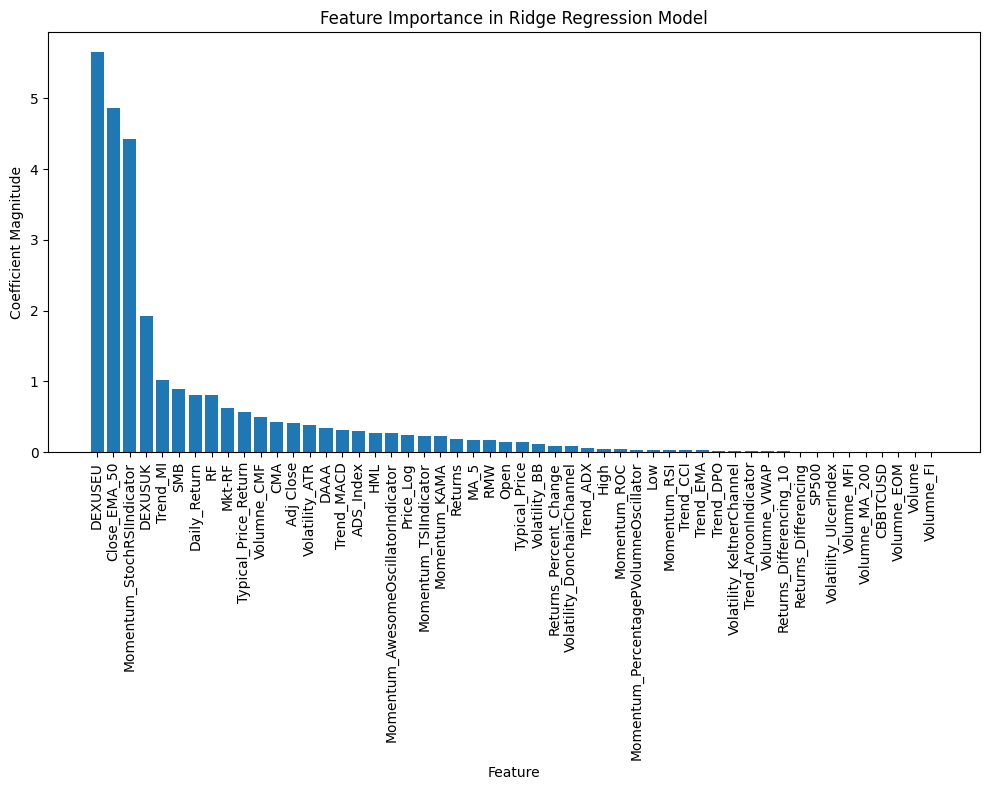

In [ ]:
# Training the Ridge regression model
ridge_model = Ridge(alpha=1.0, fit_intercept=False)
ridge_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = ridge_model.predict(X_test)

# Evaluating the model's performance
mse_ridge = mean_squared_error(y_test, y_pred)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_ridge)
print("Root Mean Squared Error:", rmse_ridge)
print("R² Score:", r2_ridge)

# Visualizing the feature importance
feature_importance = np.abs(ridge_model.coef_)
indices = np.argsort(np.abs(feature_importance))[::-1]  # Sort by magnitude
plt.figure(figsize=(10, 8))
plt.bar(range(X_train.shape[1]), feature_importance[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title('Feature Importance in Ridge Regression Model')
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.tight_layout()
plt.show()

DEXUSEU

Close_EMA_50

Momentum_StochRSIIndicator

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.703e+04, tolerance: 1.332e+03
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error: 100.52030211122214
Root Mean Squared Error (RMSE): 10.025981354023262
R² Score: 0.9100528892697571


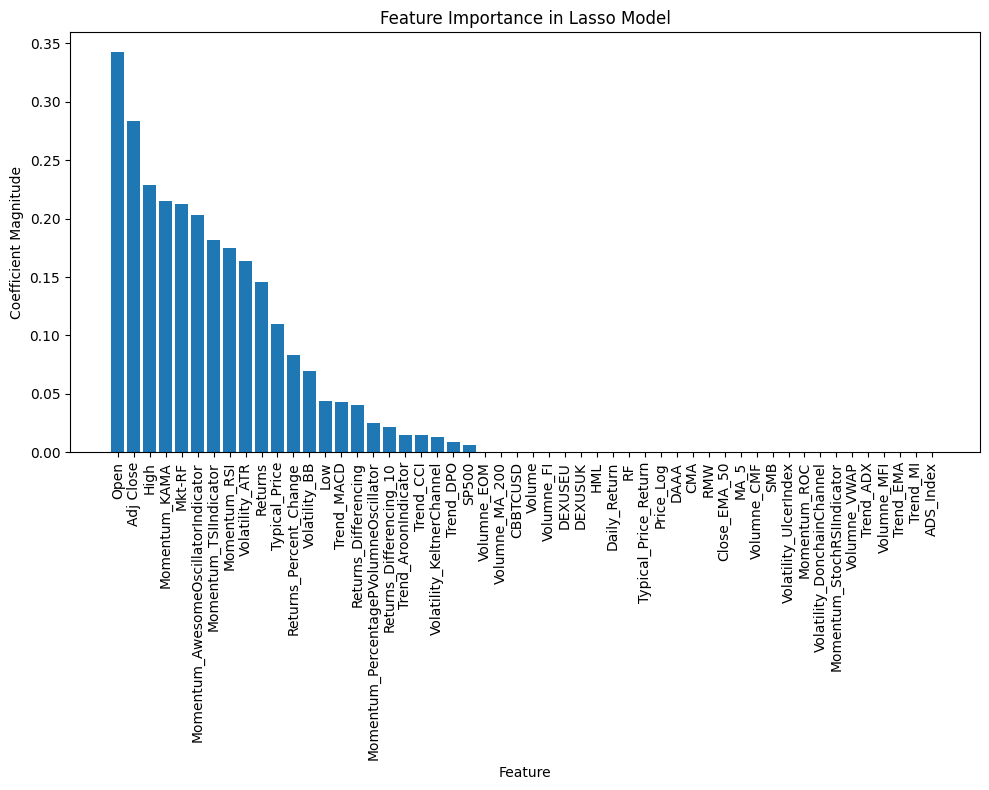

In [ ]:
# Setting up the Lasso model. Adjust 'alpha' as needed:
# - 'alpha' controls the strength of the regularization.
lasso = Lasso(alpha=1.0, random_state=42)

# Training the Lasso model
lasso.fit(X_train, y_train)

# Predicting on the test set
y_pred = lasso.predict(X_test)

# Evaluating the model's performance
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", lasso_mse)
print("Root Mean Squared Error (RMSE):", lasso_rmse)
print("R² Score:", lasso_r2)

# Visualizing the feature importance
feature_importance = np.abs(lasso.coef_)
indices = np.argsort(np.abs(feature_importance))[::-1]  # Sort by magnitude
plt.figure(figsize=(10, 8))
plt.bar(range(X_train.shape[1]), feature_importance[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title('Feature Importance in Lasso Model')
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.tight_layout()
plt.show()

Open

Adj Close

High

Momentum_KAMA

Mkt-RF

Momentum_AwesomeOscillatorIndicator

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.631e+04, tolerance: 1.332e+03
  model = cd_fast.enet_coordinate_descent(


Root Mean Squared Error (RMSE): 10.009131909446065


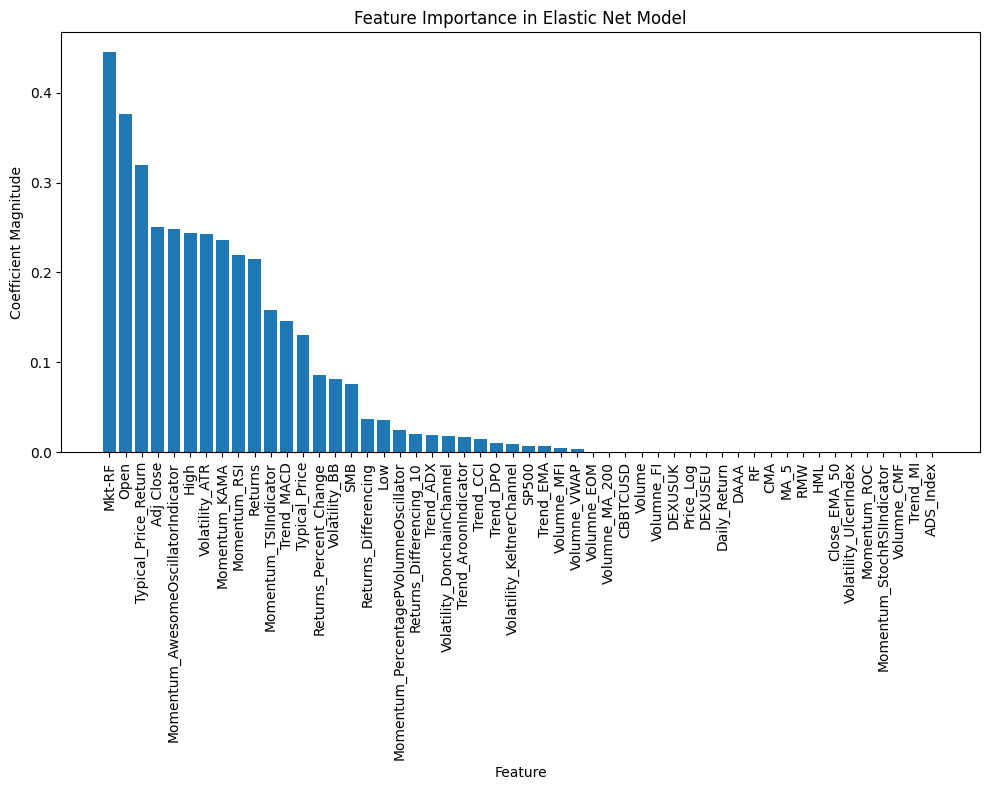

In [ ]:
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)

# Training the Elastic Net model
elastic_net.fit(X_train, y_train)

# Predicting on the test set
y_pred = elastic_net.predict(X_test)

# Evaluating the model's performance
elastic_net_mse = mean_squared_error(y_test, y_pred)
elastic_net_rmse = np.sqrt(elastic_net_mse)
elastic_net_r2 = r2_score(y_test, y_pred)

# print("Mean Squared Error:", mse)
print("Root Mean Squared Error (RMSE):", elastic_net_rmse)

# Visualizing the feature importance
feature_importance = np.abs(elastic_net.coef_)
indices = np.argsort(np.abs(feature_importance))[::-1]  # Sort by magnitude
plt.figure(figsize=(10, 8))
plt.bar(range(X_train.shape[1]), feature_importance[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title('Feature Importance in Elastic Net Model')
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.tight_layout()
plt.show()

Mkt-RF

Open

Typical_Price_Return

Adj Close

Momentum_AwesomeOscillatorIndicator

High

Volatility_ATR

Momentum_KAMA

Momentum_RSI

Returns

Root Mean Squared Error (RMSE): 19.978317928331727
R² Score: 0.6428494917418495


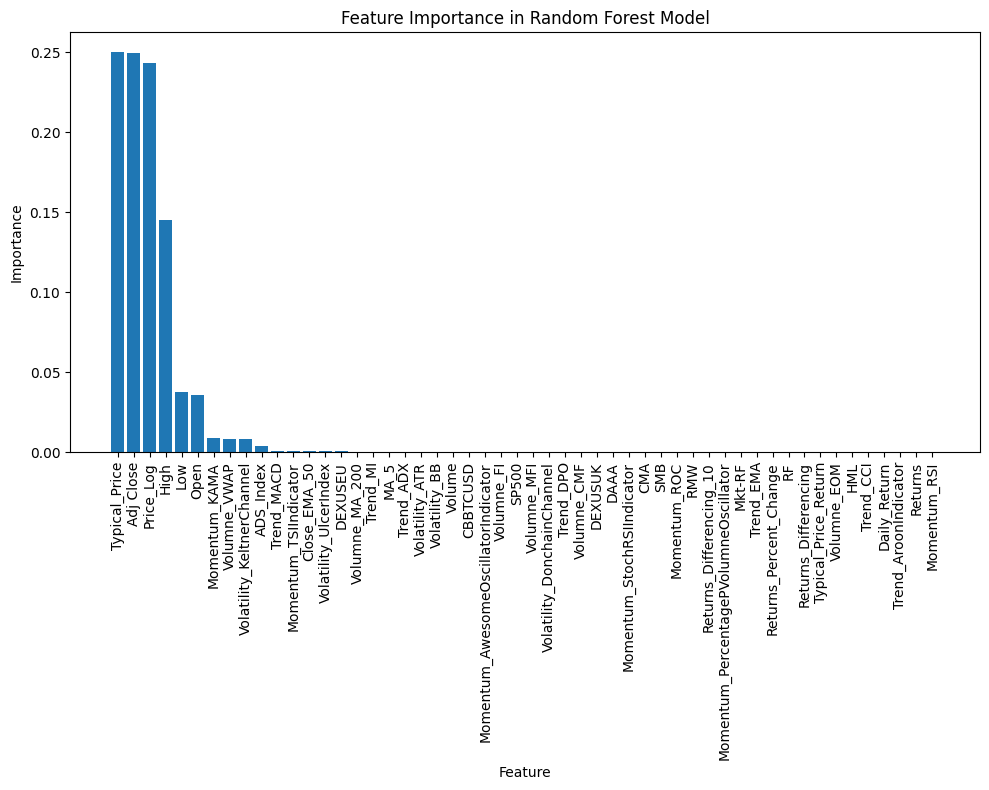

In [ ]:
# Setting up the Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the Random Forest model
random_forest.fit(X_train, y_train)

# Predicting on the test set
y_pred = random_forest.predict(X_test)

# Evaluating the model's performance
random_forest_mse = mean_squared_error(y_test, y_pred)
random_forest_rmse = np.sqrt(random_forest_mse)
random_forest_r2 = r2_score(y_test, y_pred)

# print("Mean Squared Error:", mse)
print("Root Mean Squared Error (RMSE):", random_forest_rmse)
print("R² Score:", random_forest_r2)

# Visualizing the feature importance
feature_importances = random_forest.feature_importances_
indices = np.argsort(feature_importances)[::-1]  # Sort by importance
plt.figure(figsize=(10, 8))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

Typical_Price

Adj Close

Price_Log

High

Root Mean Squared Error (RMSE): 26.82896085509579
R² Score: 0.3559180388697323


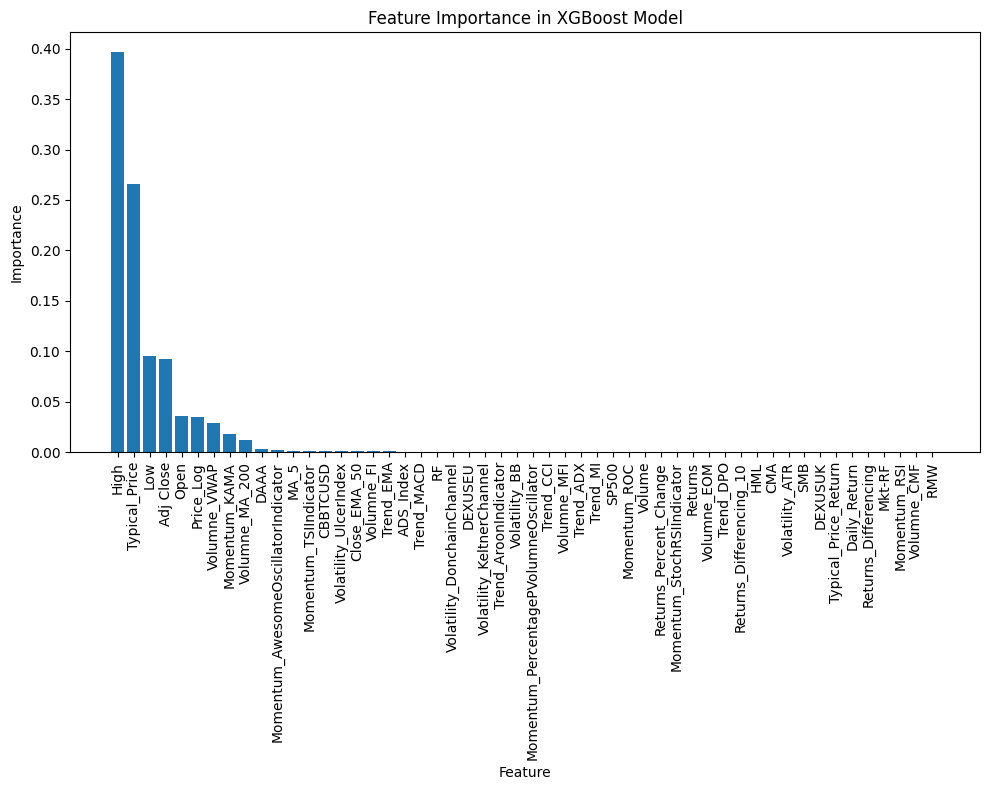

In [ ]:
# Setting up the XGBoost Regressor
xgboost_model = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                                 max_depth = 5, alpha = 10, n_estimators = 100)

# Training the XGBoost model
xgboost_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgboost_model.predict(X_test)

# Evaluating the model's performance
xgboost_mse = mean_squared_error(y_test, y_pred)
xgboost_rmse = np.sqrt(xgboost_mse)
xgboost_r2 = r2_score(y_test, y_pred)

# print("Mean Squared Error:", mse)
print("Root Mean Squared Error (RMSE):", xgboost_rmse)
print("R² Score:", xgboost_r2)

# Visualizing the feature importance
feature_importances = xgboost_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]  # Sort by importance
plt.figure(figsize=(10, 8))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title('Feature Importance in XGBoost Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

High

Typical_Price

Low

Adj Close

# 6 Model Training and comparision of RMSE between all the models

In [ ]:
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (15, 20)

In [ ]:
nflx = pd.read_csv("/content/NFLX_STOCK_WithFeatures.csv")

In [ ]:
start_date = datetime(2023, 5, 31)
end_date = datetime(2023, 12, 31)

NFLX_STOCK = yf.download("NFLX", start_date, end_date)
# NFLX_STOCK.head()
NFLX_STOCK["Returns"] = NFLX_STOCK["Adj Close"] - NFLX_STOCK["Adj Close"].shift(1)
NFLX_STOCK.head()

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-31  391.890015  396.260010  388.910004  395.230011  395.230011   
2023-06-01  397.410004  407.519989  393.079987  403.130005  403.130005   
2023-06-02  402.890015  406.579987  395.899994  400.470001  400.470001   
2023-06-05  400.470001  413.859985  400.149994  403.540009  403.540009   
2023-06-06  405.000000  405.119995  396.929993  399.290009  399.290009   

             Volume   Returns  
Date                           
2023-05-31  6988000       NaN  
2023-06-01  7160100  7.899994  
2023-06-02  5897300 -2.660004  
2023-06-05  7247400  3.070007  
2023-06-06  4991500 -4.250000

In [ ]:
nflx.set_index("Unnamed: 0", inplace=True)

nflx.index = pd.to_datetime(nflx.index)
nflx = nflx[nflx.index >= pd.to_datetime("2020-01-01")]
split_date = pd.to_datetime("2023-05-31")

df_train = nflx[nflx.index <= split_date]
df_test = nflx[nflx.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price", "Adj Close"]

X_train = df_train
X_train = X_train.drop("Close", axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test
X_test = X_test.drop("Close", axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 649
Number of rows in df_test: 145


In [ ]:
nflx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 794 entries, 2020-10-19 to 2023-12-29
Data columns (total 53 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Open                                   794 non-null    float64
 1   High                                   794 non-null    float64
 2   Low                                    794 non-null    float64
 3   Close                                  794 non-null    float64
 4   Adj Close                              794 non-null    float64
 5   Volume                                 794 non-null    float64
 6   Returns                                794 non-null    float64
 7   Daily_Return                           794 non-null    float64
 8   Typical_Price                          794 non-null    float64
 9   Typical_Price_Return                   794 non-null    float64
 10  Price_Log                              794 non-null    

In [ ]:
Model_Performances = pd.DataFrame(columns=['Model', 'RMSE'])
def add_rmse_score(model_name, rmse_score):
    global Model_Performances
    # Create a new DataFrame for the new row
    new_row = pd.DataFrame({'Model': [model_name], 'RMSE': [rmse_score],'Profit':[trade_txn_df['Total($)'].iloc[-1]-10000]})
    # Use concat to add the new row to the existing DataFrame
    Model_Performances = pd.concat([Model_Performances, new_row], ignore_index=True)

## Trading Function

In [ ]:
def merge_results(y_test, y_pred, NVDA_STOCK):
    y_test = y_test.to_frame(name="Actual")
    y_test = y_test.rename_axis("Date")

    y_pred = pd.Series(y_pred, index=y_test.index)
    y_pred = y_pred.to_frame(name="Predicted")
    y_pred = y_pred.rename_axis("Date")

    results = NVDA_STOCK.merge(y_test, left_index=True, right_index=True, how="inner")
    results = results.merge(y_pred, left_index=True, right_index=True, how="inner")
    results = results[["Actual", "Predicted", "Open", "Close"]]

    return results

In [ ]:
def execute_trade(result_df, among):
    signal = 0
    amount = 10000
    Amount = []
    balance = 0
    action = []
    portfolio = 0
    Portfolio = []
    stocks = 0
    Stocks = []
    log_df = []

    for i in range(len(result_df) - 1):
        if result_df["Predicted"][i + 1] > result_df["Actual"][i]:
            if signal == 0:
                action.append("Buy")
                stocks = int(amount / result_df["Actual"][i])
                balance = int(amount % result_df["Actual"][i])
                portfolio = stocks * result_df["Actual"][i]
                signal = 1
                amount = portfolio + balance
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)
            else:
                action.append("Bought-Holding")
                portfolio = stocks * result_df["Actual"][i]
                amount = portfolio + balance
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)

        elif result_df["Predicted"][i + 1] < result_df["Actual"][i]:
            if signal == 1:
                action.append("Sell")
                portfolio = stocks * result_df["Actual"][i]

                signal = 0
                stocks = 0
                amount = balance + portfolio
                portfolio = 0
                balance = 0
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)
            else:
                action.append("Price-Prediction-Already-Lower")
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)

    Strategy_Result = pd.DataFrame(
        {
            "Actual_Close_Price": result_df.Close[1:],
            "Predicted_Close_Price": result_df.Predicted[1:],
            "Date": result_df.index[1:],
            "Amount($)": Amount,
        }
    )

    tnx_log = pd.DataFrame(log_df)

    return tnx_log, Strategy_Result

## Data Preprocessing

In [ ]:
# Dropping the last NaN value from y_train and y_test which resulted from the shift operation
y_train = y_train.dropna()
y_test = y_test.dropna()

# Adjusting X_train and X_test to match the length of y_train and y_test
X_train = X_train.iloc[:len(y_train)]
X_test = X_test.iloc[:len(y_test)]

## XGBoost

In [ ]:
X_train_xgb = X_train[['High',  'Typical_Price', 'Low', 'Adj Close']]

X_test_xgb = X_test[['High',  'Typical_Price', 'Low', 'Adj Close']]

# Define the hyperparameters to tune
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 5),
    'learning_rate': uniform(0.01, 0.3),
}

# Number of iterations for RandomizedSearch
n_iter_search = 20

# Initialize the XGBRegressor
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_distributions,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_xgb, y_train)

# Best parameters and RMSE
best_params = random_search.best_params_
best_rmse = math.sqrt(-random_search.best_score_)

print(f"Best parameters found: {best_params}")
print(f"Best RMSE from RandomizedSearch: {best_rmse:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'learning_rate': 0.023999698964084628, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 370}
Best RMSE from RandomizedSearch: 55.85


In [ ]:
# Retrain the model on the full training set with the best parameters
best_xgb_reg = XGBRegressor(**best_params, random_state=42)
best_xgb_reg.fit(X_train_xgb, y_train)

# Predict on the test set
y_pred = best_xgb_reg.predict(X_test_xgb)

# Calculate RMSE for the test set
xgb_test_mse = mean_squared_error(y_test, y_pred)
xgb_test_rmse = np.sqrt(xgb_test_mse)

print(f"Test RMSE: {xgb_test_rmse:.2f}")

Test RMSE: 18.17


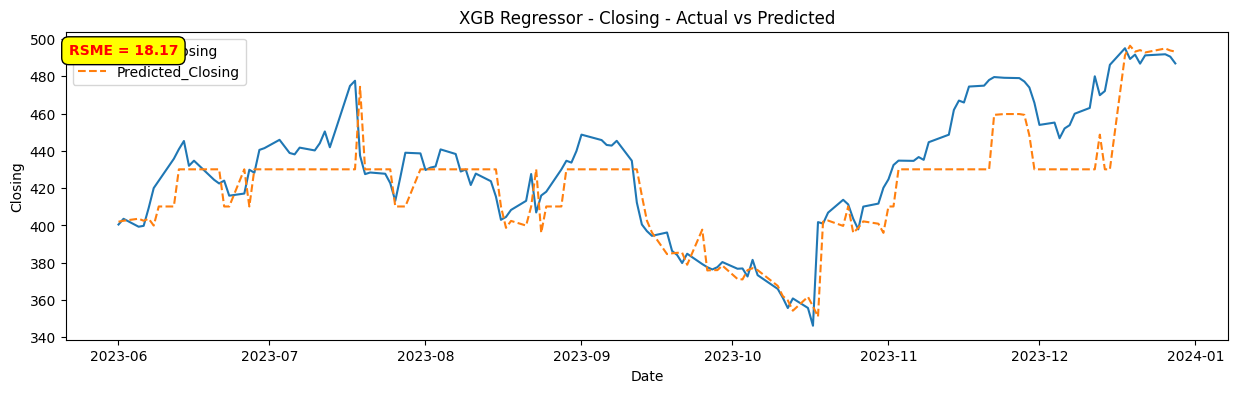

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred, NFLX_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Closing", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Closing",
    linestyle="dashed",
)
plt.title("XGB Regressor - Closing - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Closing")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {xgb_test_rmse:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

Date       Stock          Action  Portfolio  Stocks  Balance_init  \
0   2023-06-01  400.470001             Buy    9611.28      24           388   
1   2023-06-02  403.540009  Bought-Holding    9684.96      24           388   
2   2023-06-05  399.290009  Bought-Holding    9582.96      24           388   
3   2023-06-06  399.769989  Bought-Holding    9594.48      24           388   
4   2023-06-07  409.369995            Sell       0.00       0             0   
..         ...         ...             ...        ...     ...           ...   
138 2023-12-20  491.609985  Bought-Holding   10815.42      22           122   
139 2023-12-21  486.760010  Bought-Holding   10708.72      22           122   
140 2023-12-22  491.190002  Bought-Holding   10806.18      22           122   
141 2023-12-26  491.790009  Bought-Holding   10819.38      22           122   
142 2023-12-27  490.510010  Bought-Holding   10791.22      22           122   

     Total($)  
0     9999.28  
1    10072.96  
2     9970.96  
3     9982.48  
4    10212.88  
..        ...  
138  10937.42  
139  10830.72  
140  10928.18  
141  10941.38  
142  10913.22  

[143 rows x 7 columns]

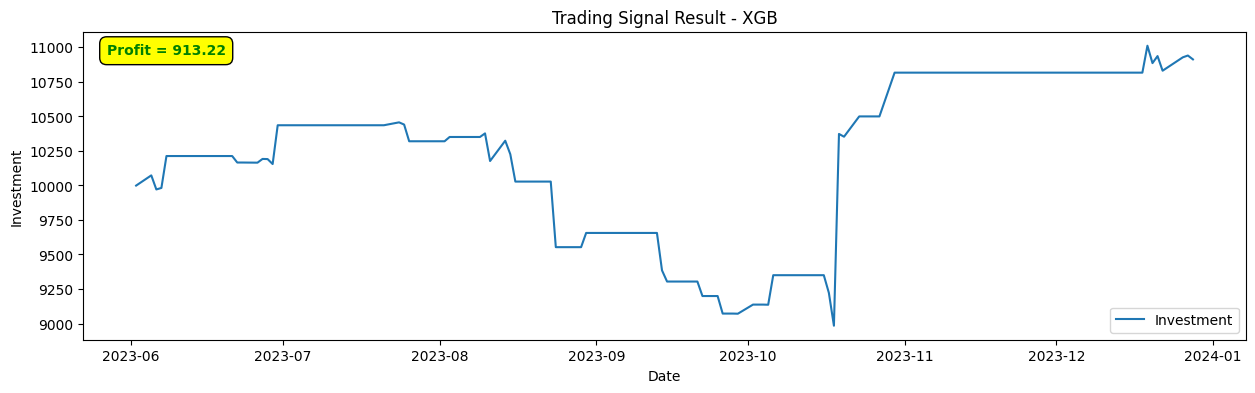

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Closing", linestyle="solid")
plt.title("Trading Signal Result - XGB")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
add_rmse_score('XG Boost', str(xgb_test_rmse))

In [ ]:
Model_Performances.head()

Model               RMSE  Profit
0  XG Boost  18.17210310545421  913.22

## Random Forest

In [ ]:
# Define the hyperparameters to tune
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'min_samples_leaf': randint(1, 5),
    'min_samples_split': randint(2, 10)
}

# Number of iterations for RandomizedSearch
n_iter_search = 20

# Initialize the RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_reg, param_distributions=param_distributions,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and RMSE
best_params = random_search.best_params_
best_rmse = math.sqrt(-random_search.best_score_)

print(f"Best parameters found: {best_params}")
print(f"Best RMSE from RandomizedSearch: {best_rmse:.2f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 443}
Best RMSE from RandomizedSearch: 57.64


In [ ]:
# Retrain the model on the full training set with the best parameters
best_rf_reg = RandomForestRegressor(**best_params, random_state=42)
best_rf_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rf_reg.predict(X_test)

# Calculate RMSE for the test set
rf_test_mse = mean_squared_error(y_test, y_pred)
rf_test_rmse = np.sqrt(rf_test_mse)

print(f"Test RMSE: {rf_test_rmse:.2f}")

Test RMSE: 17.57


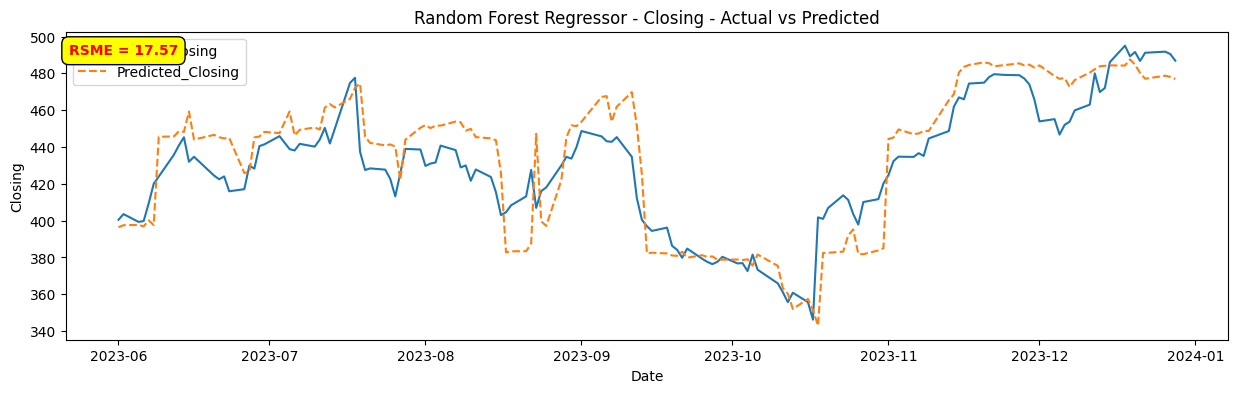

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred, NFLX_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Closing", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Closing",
    linestyle="dashed",
)
plt.title("Random Forest Regressor - Closing - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Closing")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {rf_test_rmse:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

Date       Stock                          Action  Portfolio  Stocks  \
0   2023-06-01  400.470001  Price-Prediction-Already-Lower       0.00       0   
1   2023-06-02  403.540009  Price-Prediction-Already-Lower       0.00       0   
2   2023-06-05  399.290009  Price-Prediction-Already-Lower       0.00       0   
3   2023-06-06  399.769989                             Buy    9994.25      25   
4   2023-06-07  409.369995                            Sell       0.00       0   
..         ...         ...                             ...        ...     ...   
138 2023-12-20  491.609985  Price-Prediction-Already-Lower       0.00       0   
139 2023-12-21  486.760010  Price-Prediction-Already-Lower       0.00       0   
140 2023-12-22  491.190002  Price-Prediction-Already-Lower       0.00       0   
141 2023-12-26  491.790009  Price-Prediction-Already-Lower       0.00       0   
142 2023-12-27  490.510010  Price-Prediction-Already-Lower       0.00       0   

     Balance_init  Total($)  
0               0  10000.00  
1               0  10000.00  
2               0  10000.00  
3               5   9999.25  
4               0  10239.25  
..            ...       ...  
138             0  11059.64  
139             0  11059.64  
140             0  11059.64  
141             0  11059.64  
142             0  11059.64  

[143 rows x 7 columns]

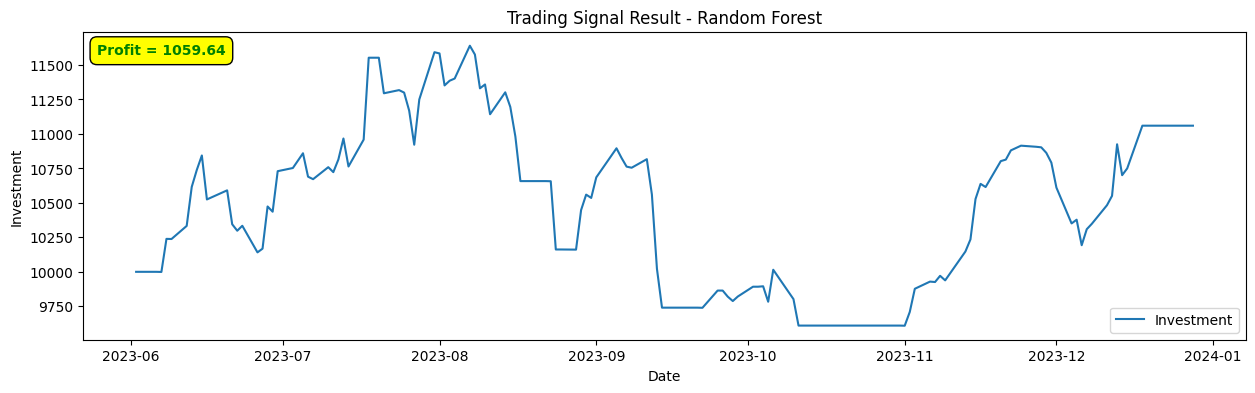

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Closing", linestyle="solid")
plt.title("Trading Signal Result - Random Forest")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
add_rmse_score('Random Forest Regressor', str(rf_test_rmse))

In [ ]:
Model_Performances.head()

Model                RMSE   Profit
0                 XG Boost   18.17210310545421   913.22
1  Random Forest Regressor  17.570165849965633  1059.64

## Ridge Regression

In [ ]:
# Define the hyperparameters to tune
param_distributions = {
    'alpha': uniform(0.1, 100)  # Uniform distribution over a range 0.1 to 100
}

# Number of iterations for RandomizedSearch
n_iter_search = 20

# Initialize the Ridge regressor
ridge_reg = Ridge(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=ridge_reg, param_distributions=param_distributions,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and RMSE
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print(f"Best parameters found: {best_params}")
print(f"Best RMSE from RandomizedSearch: {best_rmse:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.09081e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.0036e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.0313e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.41876e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Best parameters found: {'alpha': 97.09098521619943}
Best RMSE from RandomizedSearch: 16.04


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.03319e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.87319e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.41806e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.77797e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

In [ ]:
# Retrain the model on the full training set with the best parameters
best_ridge_reg = Ridge(**best_params, random_state=42)
best_ridge_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = best_ridge_reg.predict(X_test)

# Calculate RMSE for the test set
ridge_test_mse = mean_squared_error(y_test, y_pred)
ridge_test_rmse = np.sqrt(ridge_test_mse)

print(f"Test RMSE: {ridge_test_rmse:.2f}")

Test RMSE: 9.98


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.19196e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


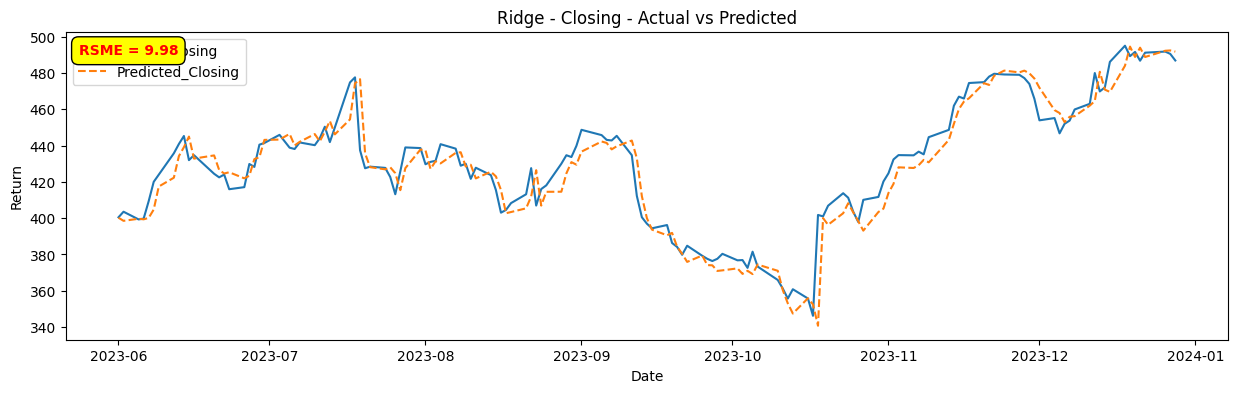

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred, NFLX_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Closing", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Closing",
    linestyle="dashed",
)
plt.title("Ridge - Closing - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {ridge_test_rmse:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

Date       Stock                          Action  Portfolio  Stocks  \
0   2023-06-01  400.470001  Price-Prediction-Already-Lower       0.00       0   
1   2023-06-02  403.540009  Price-Prediction-Already-Lower       0.00       0   
2   2023-06-05  399.290009                             Buy    9982.25      25   
3   2023-06-06  399.769989                  Bought-Holding    9994.25      25   
4   2023-06-07  409.369995                            Sell       0.00       0   
..         ...         ...                             ...        ...     ...   
138 2023-12-20  491.609985                             Buy   11798.64      24   
139 2023-12-21  486.760010                  Bought-Holding   11682.24      24   
140 2023-12-22  491.190002                  Bought-Holding   11788.56      24   
141 2023-12-26  491.790009                  Bought-Holding   11802.96      24   
142 2023-12-27  490.510010                  Bought-Holding   11772.24      24   

     Balance_init  Total($)  
0               0  10000.00  
1               0  10000.00  
2              17   9999.25  
3              17  10011.25  
4               0  10251.25  
..            ...       ...  
138           285  12083.64  
139           285  11967.24  
140           285  12073.56  
141           285  12087.96  
142           285  12057.24  

[143 rows x 7 columns]

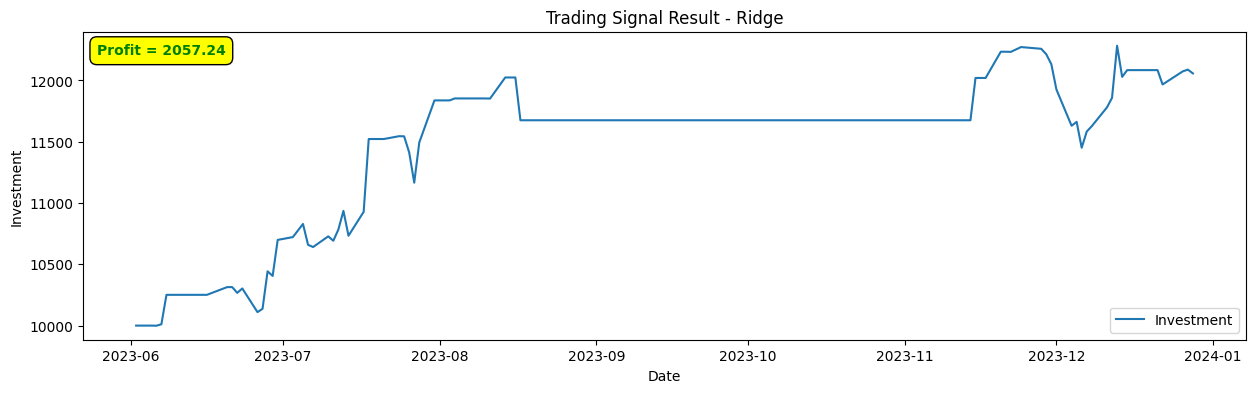

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Closing", linestyle="solid")
plt.title("Trading Signal Result - Ridge")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
add_rmse_score('Ridge Regression', str(ridge_test_rmse))

In [ ]:
Model_Performances.head()

Model                RMSE   Profit
0                 XG Boost   18.17210310545421   913.22
1  Random Forest Regressor  17.570165849965633  1059.64
2         Ridge Regression   9.975577259013441  2057.24

## Lasso Regression


In [ ]:
X_train_lasso = X_train[['Open', 'Adj Close', 'High', 'Momentum_KAMA', 'Mkt-RF', 'Momentum_AwesomeOscillatorIndicator']]
X_test_lasso = X_test[['Open', 'Adj Close', 'High', 'Momentum_KAMA', 'Mkt-RF', 'Momentum_AwesomeOscillatorIndicator']]

In [ ]:
# Define the hyperparameters to tune
param_distributions = {
    'alpha': uniform(0.001, 1)  # Uniform distribution over a range from 0.001 to 1
}

# Number of iterations for RandomizedSearch
n_iter_search = 50

# Initialize the Lasso regressor
lasso = Lasso(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lasso, param_distributions=param_distributions,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_lasso, y_train)

# Best parameters and RMSE
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print(f"Best parameters found: {best_params}")
print(f"Best RMSE from RandomizedSearch: {best_rmse:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.377e+04, tolerance: 1.140e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.823e+04, tolerance: 9.687e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.337e+04, tolerance: 1.022e

Best parameters found: {'alpha': 0.9709098521619943}
Best RMSE from RandomizedSearch: 12.58


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+04, tolerance: 7.513e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.694e+04, tolerance: 1.207e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.426e+04, tolerance: 1.140e

In [ ]:
# Retrain the model on the full training set with the best parameters
best_lasso = Lasso(**best_params, random_state=42)
best_lasso.fit(X_train_lasso, y_train)

# Predict on the test set
y_pred = best_lasso.predict(X_test_lasso)

# Calculate RMSE for the test set
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"Test RMSE: {test_rmse:.2f}")

Test RMSE: 9.24


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e+04, tolerance: 1.332e+03
  model = cd_fast.enet_coordinate_descent(


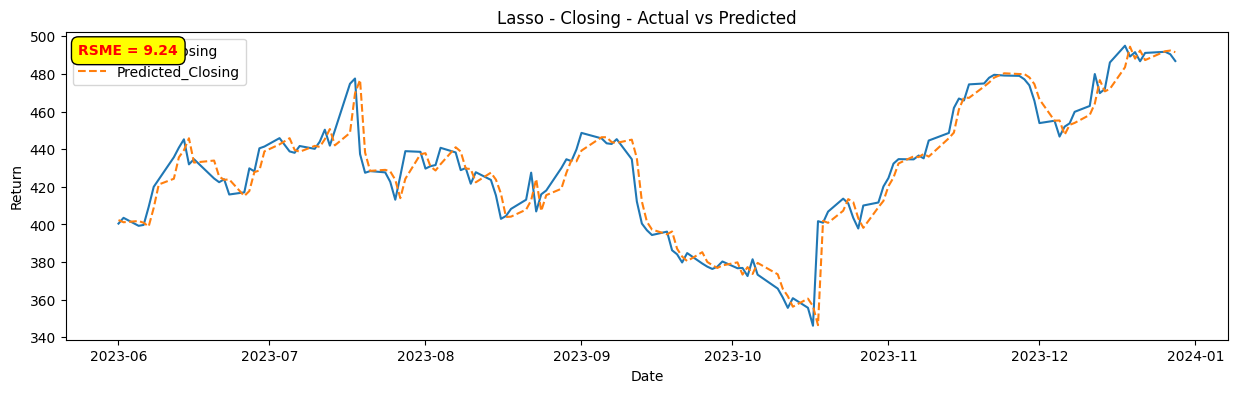

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred, NFLX_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Closing", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Closing",
    linestyle="dashed",
)
plt.title("Lasso - Closing - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {test_rmse:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

Date       Stock                          Action  Portfolio  Stocks  \
0   2023-06-01  400.470001                             Buy    9611.28      24   
1   2023-06-02  403.540009                            Sell       0.00       0   
2   2023-06-05  399.290009                             Buy    9982.25      25   
3   2023-06-06  399.769989                            Sell       0.00       0   
4   2023-06-07  409.369995  Price-Prediction-Already-Lower       0.00       0   
..         ...         ...                             ...        ...     ...   
138 2023-12-20  491.609985                             Buy   13273.47      27   
139 2023-12-21  486.760010                  Bought-Holding   13142.52      27   
140 2023-12-22  491.190002                  Bought-Holding   13262.13      27   
141 2023-12-26  491.790009                  Bought-Holding   13278.33      27   
142 2023-12-27  490.510010                  Bought-Holding   13243.77      27   

     Balance_init  Total($)  
0             388   9999.28  
1               0  10072.96  
2              90  10072.25  
3               0  10084.25  
4               0  10084.25  
..            ...       ...  
138           409  13682.47  
139           409  13551.52  
140           409  13671.13  
141           409  13687.33  
142           409  13652.77  

[143 rows x 7 columns]

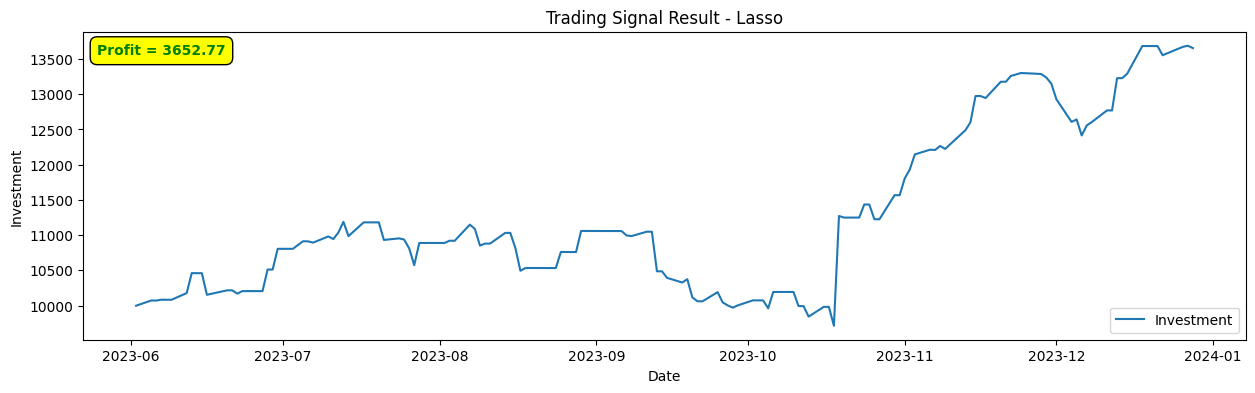

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Closing", linestyle="solid")
plt.title("Trading Signal Result - Lasso")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
add_rmse_score('Lasso Regression', str(test_rmse))

In [ ]:
Model_Performances.head()

Model                RMSE   Profit
0                 XG Boost   18.17210310545421   913.22
1  Random Forest Regressor  17.570165849965633  1059.64
2         Ridge Regression   9.975577259013441  2057.24
3         Lasso Regression   9.237028424508397  3652.77

## ElasticNet Regression

In [ ]:
# Define the hyperparameters to tune
param_distributions = {
    'alpha': uniform(0.1, 10),  # Uniform distribution over a range 0.1 to 10
    'l1_ratio': uniform(0, 1)  # Uniform distribution between 0 and 1 for l1_ratio
}

# Number of iterations for RandomizedSearch
n_iter_search = 50

# Initialize the ElasticNet regressor
elastic_net = ElasticNet(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=elastic_net, param_distributions=param_distributions,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error', verbose=1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and RMSE
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print(f"Best parameters found: {best_params}")
print(f"Best RMSE from RandomizedSearch: {best_rmse:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.745e+04, tolerance: 1.140e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.400e+04, tolerance: 9.687e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.692e+04, tolerance: 1.022e

Best parameters found: {'alpha': 0.35419126744095186, 'l1_ratio': 0.10789142699330445}
Best RMSE from RandomizedSearch: 13.17


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.999e+04, tolerance: 9.687e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.388e+04, tolerance: 1.022e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.929e+04, tolerance: 7.513e

In [ ]:
# Retrain the model on the full training set with the best parameters
best_elastic_net = ElasticNet(**best_params, random_state=42)
best_elastic_net.fit(X_train, y_train)

# Predict on the test set
y_pred = best_elastic_net.predict(X_test)

# Calculate RMSE for the test set
test_mse = mean_squared_error(y_test, y_pred)
EN_test_rmse = np.sqrt(test_mse)


add_rmse_score('ElasticNet Regression', str(EN_test_rmse))

print(f"Test RMSE: {EN_test_rmse:.2f}")

Test RMSE: 9.99


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.495e+04, tolerance: 1.332e+03
  model = cd_fast.enet_coordinate_descent(


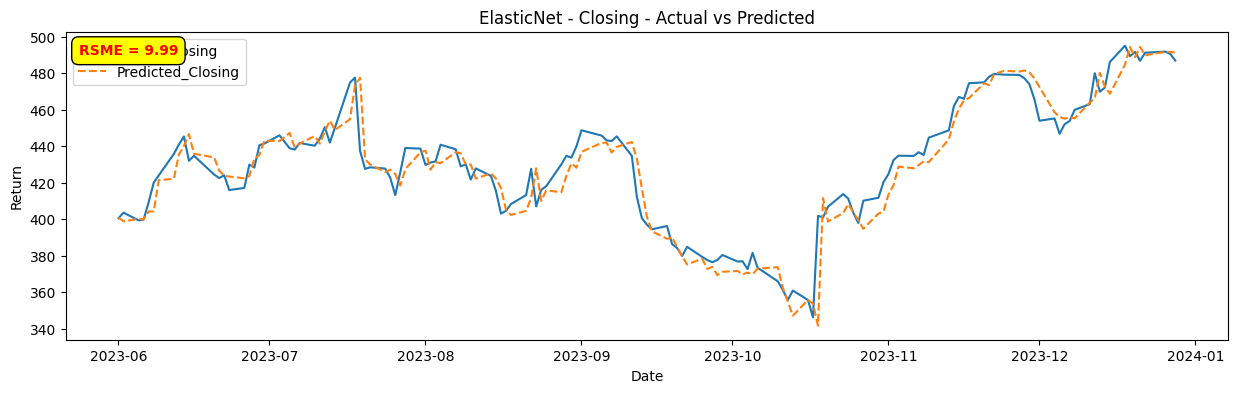

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred, NFLX_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Closing", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Closing",
    linestyle="dashed",
)
plt.title("ElasticNet - Closing - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {EN_test_rmse:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

Date       Stock                          Action  Portfolio  Stocks  \
0   2023-06-01  400.470001  Price-Prediction-Already-Lower       0.00       0   
1   2023-06-02  403.540009  Price-Prediction-Already-Lower       0.00       0   
2   2023-06-05  399.290009                             Buy    9982.25      25   
3   2023-06-06  399.769989                  Bought-Holding    9994.25      25   
4   2023-06-07  409.369995                            Sell       0.00       0   
..         ...         ...                             ...        ...     ...   
138 2023-12-20  491.609985                             Buy   10815.42      22   
139 2023-12-21  486.760010                  Bought-Holding   10708.72      22   
140 2023-12-22  491.190002                  Bought-Holding   10806.18      22   
141 2023-12-26  491.790009                            Sell       0.00       0   
142 2023-12-27  490.510010                             Buy   10791.22      22   

     Balance_init  Total($)  
0               0  10000.00  
1               0  10000.00  
2              17   9999.25  
3              17  10011.25  
4               0  10251.25  
..            ...       ...  
138           456  11271.42  
139           456  11164.72  
140           456  11262.18  
141             0  11275.38  
142           484  11275.22  

[143 rows x 7 columns]

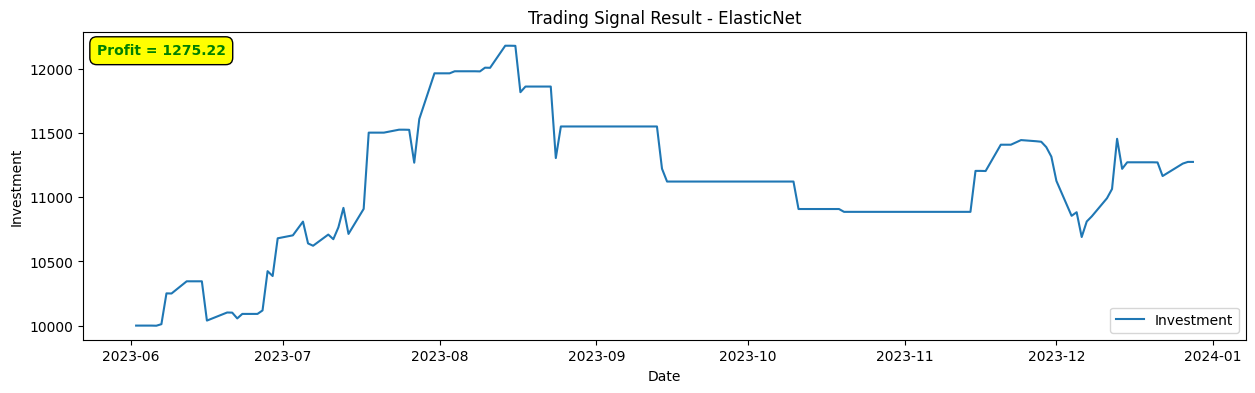

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Closing", linestyle="solid")
plt.title("Trading Signal Result - ElasticNet")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
add_rmse_score('ElasticNet Regression', str(EN_test_rmse))

In [ ]:
Model_Performances.head()

Model                RMSE   Profit
0                 XG Boost   18.17210310545421   913.22
1  Random Forest Regressor  17.570165849965633  1059.64
2         Ridge Regression   9.975577259013441  2057.24
3         Lasso Regression   9.237028424508397  3652.77
4    ElasticNet Regression   9.988773390466426  3652.77

## Quantile Regression

In [ ]:
# Add a constant to the model (the intercept term)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)  # also add constant to the test dataset

quantiles = [0.25, 0.5, 0.75]
results = []
models = []

for quantile in quantiles:
    # Fit the Quantile Regression model
    mod = sm.QuantReg(y_train, X_train_const)
    res = mod.fit(q=quantile)
    models.append(res)  # Store the model results for later use

    # Predict on the training set
    y_pred_train = res.predict(X_train_const)

    # Calculate RMSE for the training set
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    results.append(train_rmse)

    print(f"Quantile: {quantile}")
    print(f"Train RMSE: {train_rmse:.2f}")


# Find the model with the lowest RMSE
min_rmse_index = np.argmin(results)
best_model = models[min_rmse_index]
best_quantile = quantiles[min_rmse_index]

# Predict on the test set using the best model
y_pred = best_model.predict(X_test_const)

# Calculate RMSE for the test set
quantile_test_mse = mean_squared_error(y_test, y_pred)
quantile_test_rmse = np.sqrt(quantile_test_mse)

print(f"Best Quantile: {best_quantile}")
print(f"Test RMSE: {quantile_test_rmse:.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.25
Train RMSE: 13.53


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile: 0.5
Train RMSE: 12.35
Quantile: 0.75
Train RMSE: 14.34
Best Quantile: 0.5
Test RMSE: 9.95


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


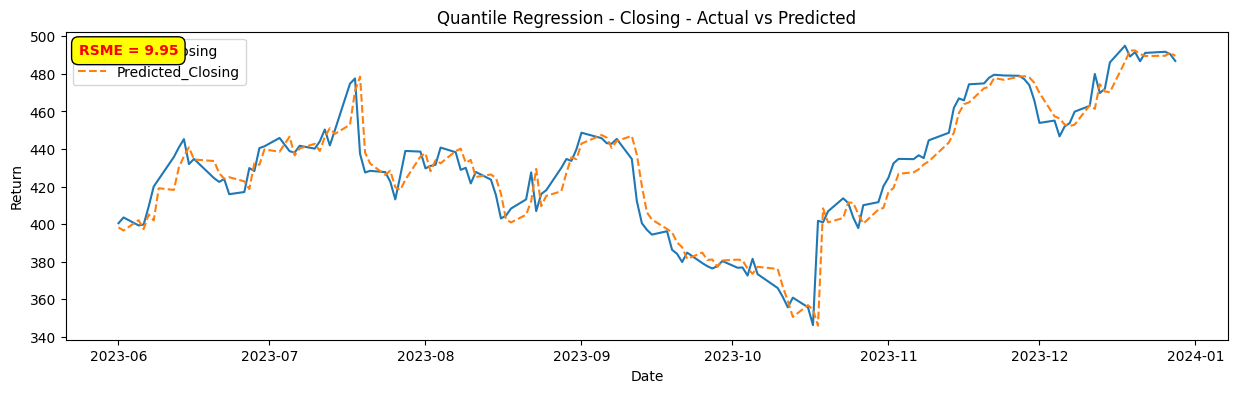

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred, NFLX_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Closing", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Closing",
    linestyle="dashed",
)
plt.title("Quantile Regression - Closing - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {quantile_test_rmse:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

Date       Stock                          Action  Portfolio  Stocks  \
0   2023-06-01  400.470001  Price-Prediction-Already-Lower       0.00       0   
1   2023-06-02  403.540009  Price-Prediction-Already-Lower       0.00       0   
2   2023-06-05  399.290009  Price-Prediction-Already-Lower       0.00       0   
3   2023-06-06  399.769989                             Buy    9994.25      25   
4   2023-06-07  409.369995                            Sell       0.00       0   
..         ...         ...                             ...        ...     ...   
138 2023-12-20  491.609985                            Sell       0.00       0   
139 2023-12-21  486.760010                             Buy    8274.92      17   
140 2023-12-22  491.190002                            Sell       0.00       0   
141 2023-12-26  491.790009  Price-Prediction-Already-Lower       0.00       0   
142 2023-12-27  490.510010  Price-Prediction-Already-Lower       0.00       0   

     Balance_init  Total($)  
0               0  10000.00  
1               0  10000.00  
2               0  10000.00  
3               5   9999.25  
4               0  10239.25  
..            ...       ...  
138             0   8524.37  
139           249   8523.92  
140             0   8599.23  
141             0   8599.23  
142             0   8599.23  

[143 rows x 7 columns]

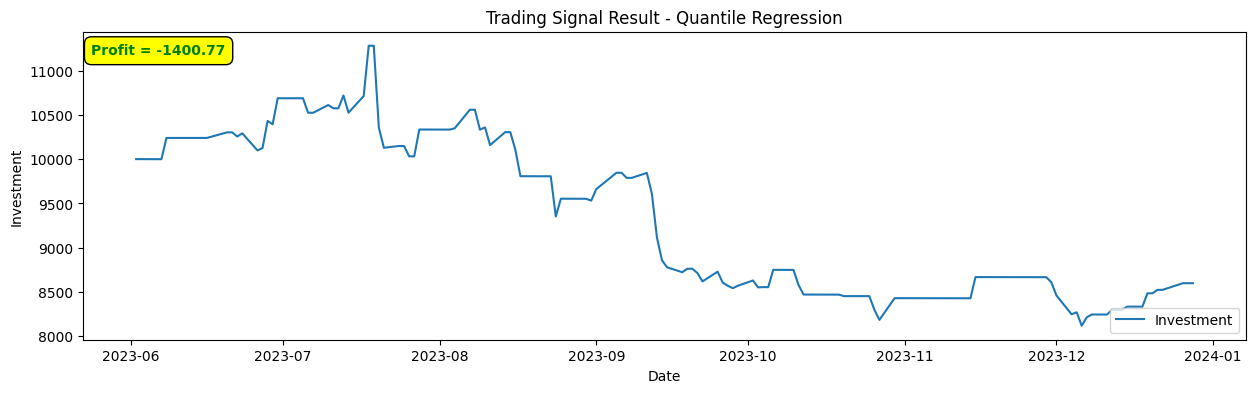

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Closing", linestyle="solid")
plt.title("Trading Signal Result - Quantile Regression")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

In [ ]:
add_rmse_score('Quantile Regression', str(quantile_test_rmse))

In [ ]:
Model_Performances

Model                RMSE   Profit
0                 XG Boost   18.17210310545421   913.22
1  Random Forest Regressor  17.570165849965633  1059.64
2         Ridge Regression   9.975577259013441  2057.24
3         Lasso Regression   9.237028424508397  3652.77
4    ElasticNet Regression   9.988773390466426  3652.77
5    ElasticNet Regression   9.988773390466426  1275.22
6      Quantile Regression   9.949446001525315 -1400.77

# Benchmark Study

## Garch

[*********************100%%**********************]  1 of 1 completed
<ipython-input-125-5f2d1a334add>:46: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(
<ipython-input-125-5f2d1a334add>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
<ipython-input-125-5f2d1a334add>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
<ipython-input-125-5f2d1a334add>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a sin

         Current function value: 13.914839
         Iterations: 3
         Function evaluations: 178
         Gradient evaluations: 32


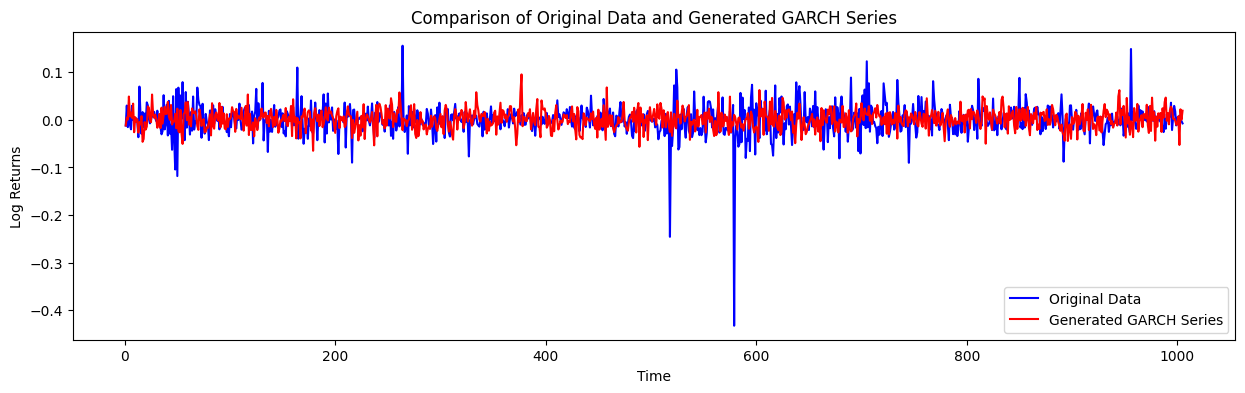

RMSE values is: 0.03771129801467224


In [ ]:
def GARCH(param, *args):
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * (sigma2[t - 1])
        F[t] = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (
            (1 / 2) * np.log(2 * np.pi)
            + (1 / 2) * np.log(v[t])
            + (1 / 2) * (F[t] / v[t])
        )
        Likelihood = np.sum(GARCH_Dens[1:-1])
        return Likelihood


def GARCH_PROD(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.003
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t - 1] - mu) ** 2) + beta * (sigma2[t - 1])
        Y[t] = mu + np.sqrt(sigma2[t]) * np.random.normal(0, 1, 1)
    return Y


start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)
NFLX = yf.download("NFLX", start_date, end_date)
Y = NFLX['Adj Close'].values
Y = np.diff(np.log(NFLX["Adj Close"].values))
T = Y.size
param0 = np.array([np.mean(Y), np.var(Y) / 4, 0.15, 0.2]) #To adjust RMSE
param_star = minimize(
    GARCH, param0, method="BFGS", options={"xtol": 1e-8, "disp": True}
)
Y_GARCH = GARCH_PROD(param_star.x, Y[0], T)
timevec = np.linspace(1, T, T)
plt.figure(figsize=(15, 4))
plt.legend()
# plt.plot(timevec, Y_GARCH, "r", timevec, Y, "b")
plt.plot(timevec, Y, "b", label='Original Data')  # Blue for original data
plt.plot(timevec, Y_GARCH, "r", label='Generated GARCH Series')  # Red for generated
RMSE = np.sqrt(np.mean((Y_GARCH - Y) ** 2))

plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Comparison of Original Data and Generated GARCH Series")
plt.legend(loc='lower right')
plt.show()
print("RMSE values is:", RMSE)

[*********************100%%**********************]  1 of 1 completed
<ipython-input-126-a7484035d426>:67: OptimizeWarning: Unknown solver options: xtol
  results = minimize(kalman_filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 3917.770803
         Iterations: 49
         Function evaluations: 769
         Gradient evaluations: 151
RMSE values is: $ 13.276310250240796


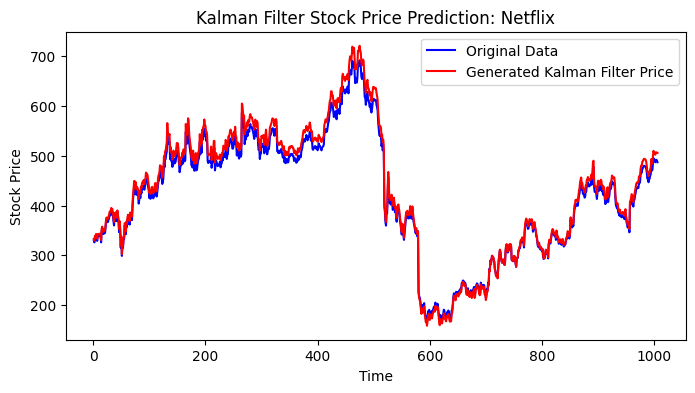

In [ ]:
# Kalman Filter
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0]
    P_update[0] = np.var(Y)/4
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H
        v[s]= Y[s-1]-Z*u_predict[s-1]
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]

    return Likelihood


def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0]
    P_update[0] = np.var(Y)/4
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H
        v[s]=Y[s-1]-Z*u_predict[s-1]
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q

    u_smooth, P_smooth = {}, {}
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]
    for t in range(S-1, 0, -1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[s])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]

    # del u_update[-1]
    smooth_path = u_smooth
    return smooth_path


start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)
stock = yf.download("NFLX",start_date ,end_date)
Y = stock['Adj Close'].values
S = Y.shape[0]

param0 = np.array([1.8, 0.97,np.var(Y)/50, np.var(Y)/50]) #To adjust RMSE

results = minimize(kalman_filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})

# Smooth and visualize the estimated path
param_star = results.x
path = kalman_smoother(param_star, Y, S)
Y_kalmanFilter = np.hstack(list(path.values()))
Y_kalmanFilter = Y_kalmanFilter[::-1]

timevec = np.linspace(1, S, S)

# Modify the figure size here
plt.figure(figsize=(8, 4))  # Smaller figure size (Width, Height in inches)
plt.title('Kalman Filter Stock Price Prediction: Netflix')
plt.plot(timevec, Y, "b", label='Original Data')  # Blue for original data
plt.plot(timevec, Y_kalmanFilter, "r", label='Generated Kalman Filter Price')  # Red for generated
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper right')

RMSE = np.sqrt(np.mean((Y_kalmanFilter - Y)**2))
print('RMSE values is: $', RMSE)

plt.show()